# Introdução

* O crescimento exponencial do e-commerce na última década trouxe consigo inúmeros benefícios, proporcionando aos consumidores uma experiência de compra mais conveniente, ágil e flexível.

* No entanto, uma ameaça se torna cada vez mais evidente aos comerciantes de e-commerce: as fraudes.

* De acordo com um estudo da Serasa Experian, as tentativas de fraude em e-commerce aumentaram em 23.6% no primeiro trimestre de 2022, em relação ao mesmo período de 2021.

* O cenário de fraudes é altamente complexo, pois fraudadores encontram novas maneiras de explorar as transações online, usando artifícios cada vez mais sofisticados para obter ganhos ilícitos.

* Nesse cenário, algorítmos de detecção de fraudes desempenham extrema importância para manter a integridade no comércio digital e maximizar seus lucros.

* No presente trabalho, é vista uma abordagem utilizando-se de técnicas de aprendizagem de máquina para detecção de fraudes em transações financeiras em e-commerce.

<img src="../../static/fraud.jpg" style="height: 800px;"/>b

## Dataset

Temos um dataset com as seguintes variáveis:

* score_1 até score_10: Notas de bureau de crédito que a empresa de e-commerce possui para identificar se o comprador é confiável, ou então outros dados anonimizados que não possuímos informação.

* pais: País o qual foi realizado a compra.

* produto: Nome do produto comprado.

* categoria_produto: Categoria do produto anonimizada.

* entrega_doc_1: Indica se o documento 1 foi entregue na criação da conta.

* entrega_doc_2: Indica se o documento 2 foi entregue na criação da conta.

* entrega_doc_3: Indica se o documento 3 foi entregue na criação da conta.

* data_compra: Data da compra.

* valor_compra: Valor da compra.

* score_fraude_modelo: Score dado pelo modelo de detecção de fraude atual.

* fraude: Informação se a compra era fraude ou não. 0 significa que não foi fraude, e 1 significa que foi fraude.

# Setup

Primeiro, vamos importar as bibliotecas que iremos utilizar ao longo do código.

In [96]:
# monitoramento de modelo 
import mlflow
import mlflow.sklearn
from sklearn.pipeline import Pipeline

# manipulação de dados
import pandas as pd
import numpy as np

# visualização e análise de dados
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# pré-processamento
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from feature_engine import imputation
from feature_engine.selection import DropFeatures
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer

# feature engineering
from feature_engine import encoding
from feature_engine.datetime import DatetimeFeatures
from category_encoders import WOEEncoder

# modelos de machine learning
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

# tuning de hiperparâmetros
from skopt import BayesSearchCV

# métricas
from sklearn import metrics
from sklearn.metrics import roc_curve, roc_auc_score

# visualização de imagens
from IPython.display import Image

Primeiro iremos importar nossos dados.

In [2]:
data = pd.read_csv('../../data/data.csv')

Vamos realizar algumas análises sobre nossos dados. Essa etapa é chamada de Exploratory Data Analysis!

# Exploratory Data Analysis (EDA)

Vamos olhar para algumas estatísticas das nossas features

In [3]:
data.describe()

,score_1,score_2,score_3,score_4,score_5,score_6,score_7,score_8,score_9,score_10,entrega_doc_1,valor_compra,score_fraude_modelo,fraude
count,150000.000000,137016.000000,1.370160e+05,149635.000000,150000.000000,149989.000000,150000.000000,150000.000000,149989.000000,149635.000000,150000.000000,150000.000000,150000.000000,150000.000000
mean,3.705407,0.728115,2.604451e+05,21.677669,0.220641,51.169352,14.193513,0.497532,2305.409403,299.969579,0.902353,43.523134,48.066240,0.050000
std,0.753206,0.132943,8.464361e+05,20.062146,2.434995,709.472904,14.161216,0.288348,1712.379601,321.075806,0.296837,91.557888,28.995122,0.217946
min,1.000000,0.000000,1.600000e-01,0.000000,0.000000,-5.000000,0.000000,0.000004,0.000000,0.000000,0.000000,0.020000,0.000000,0.000000
25%,4.000000,0.678400,9.679915e+03,2.000000,0.000000,1.000000,3.000000,0.246819,910.000000,42.000000,1.000000,9.380000,23.000000,0.000000
50%,4.000000,0.755500,4.371165e+04,14.000000,0.104875,8.000000,9.000000,0.495990,1937.000000,193.000000,1.000000,20.610000,48.000000,0.000000
75%,4.000000,0.806500,1.454436e+05,50.000000,0.282938,33.000000,21.000000,0.746508,3445.000000,459.000000,1.000000,40.692500,73.000000,0.000000
max,4.000000,1.000000,1.387874e+07,50.000000,833.333333,145274.000000,58.000000,0.999995,7544.000000,2225.000000,1.000000,3696.350000,100.000000,1.000000


Agora, iremos observar os dados faltantes

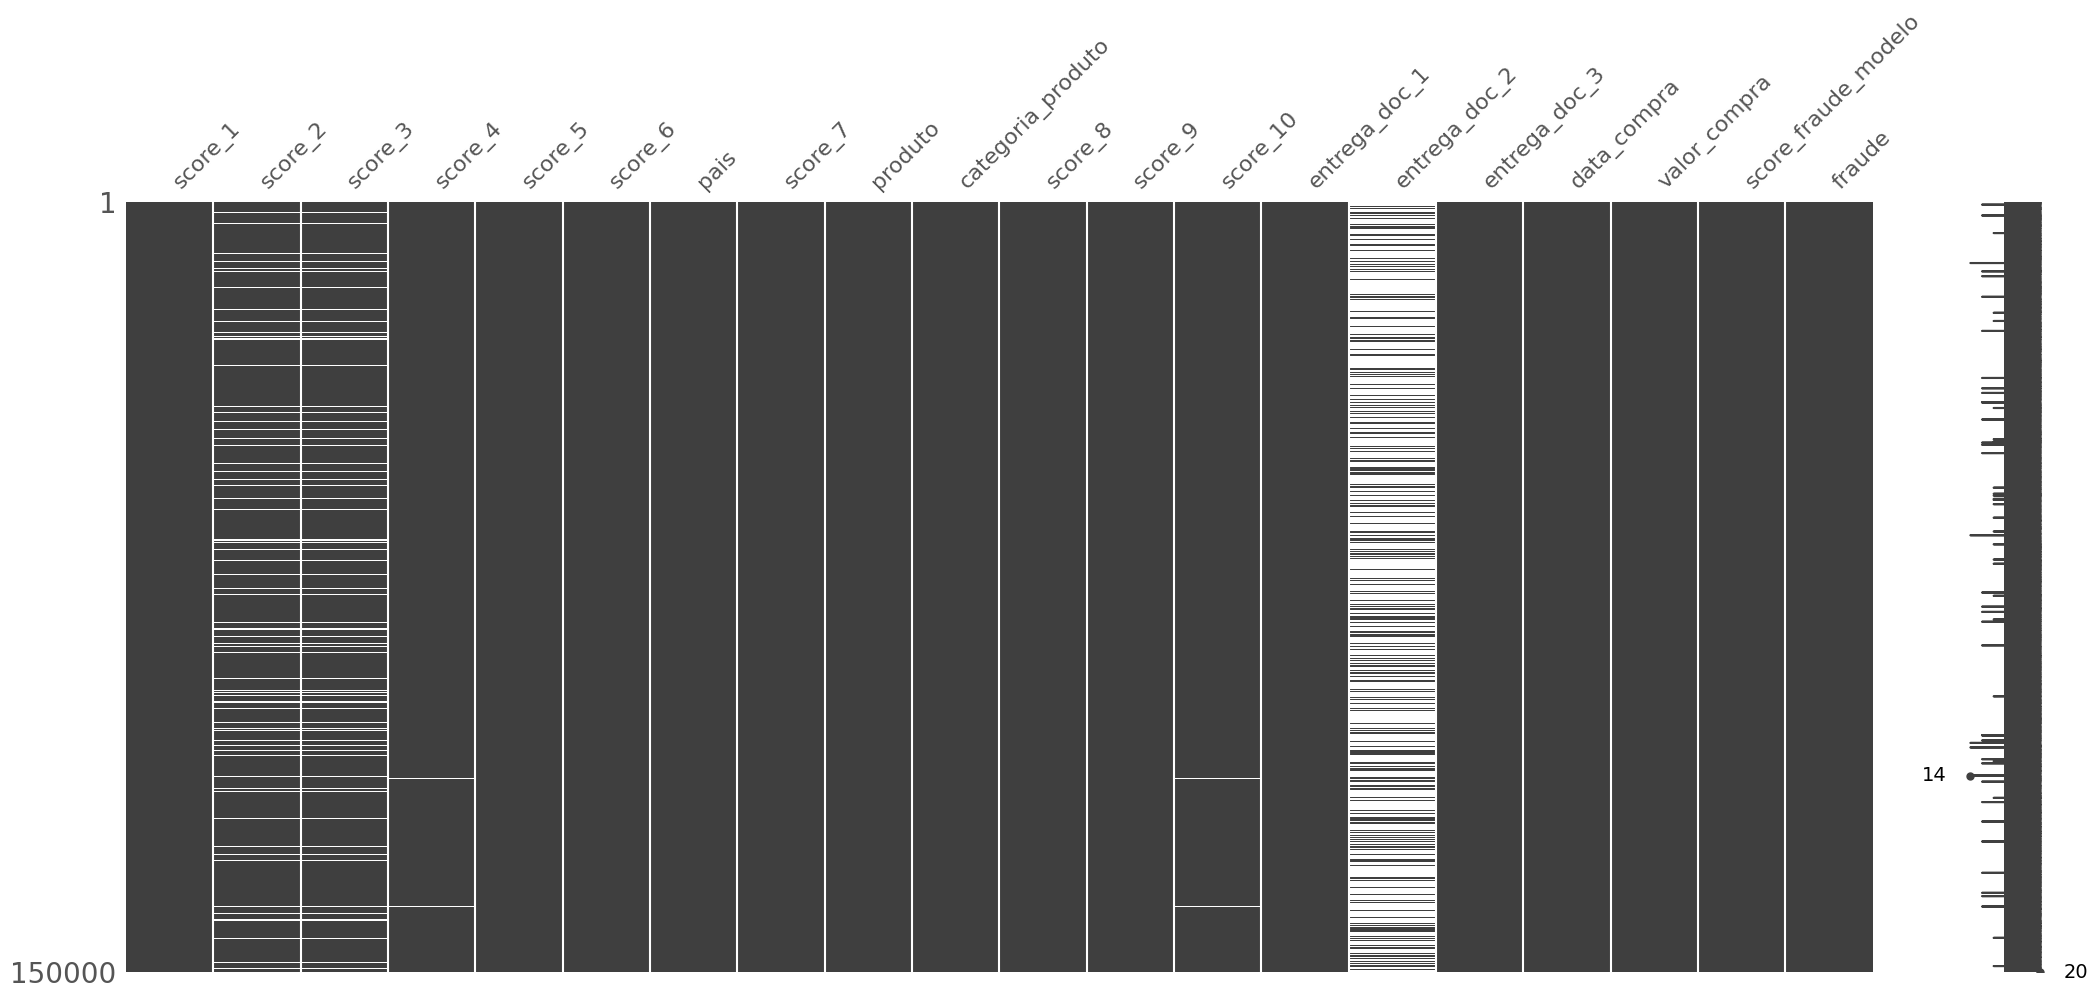

In [4]:
msno.matrix(data);

> Podemos observar um volume grande de valores missing na feature entrega_doc_2. Também há um valor considerável nas features score_2 e score_3.

Devemos nos preocupar em como tratar esses valores. Entretanto, iremos fazer isso após realizar a divisão dos nossos dados, para evitar vazamento de dados.

## Análise univariada

Vamos analisar a proporção transações fraudulentas no nosso dataset.

In [5]:
# definindo paleta de cores para os gráficos
palette = ["#0048BA", "#c41e3a"]

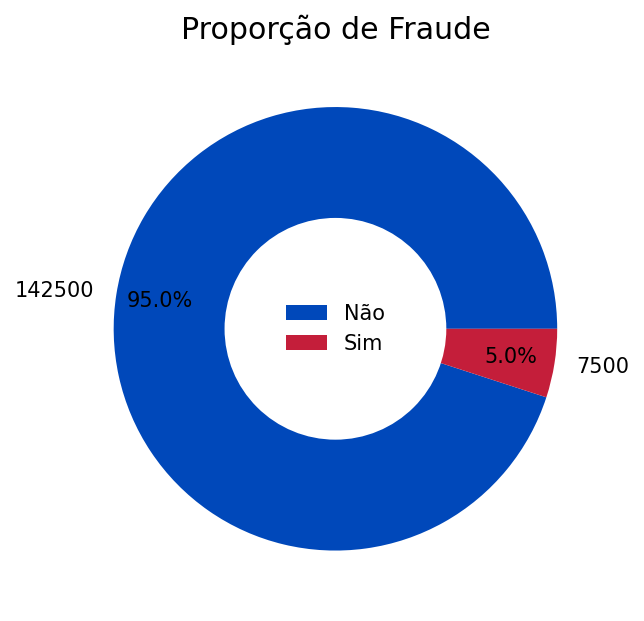

In [6]:
# criação de um gráfico de donut para representar a proporção de transações fraudulentas
donut = data["fraude"].value_counts().reset_index()

labels = ["Não", "Sim"]
explode = (0, 0)

fig, ax = plt.subplots(dpi=150)
plt.pie(donut["fraude"],
        labels=donut["fraude"],
        autopct="%1.1f%%",
        pctdistance=0.8,
        explode=explode, colors= palette)

centre_circle = plt.Circle((0.0, 0.0), 0.5, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title("Proporção de Fraude")
plt.legend(labels, loc="center", frameon=False)
plt.show();

> Podemos observar que temos um caso de target rara. Ou seja, apenas 5% das transações são fraudulentas.

Agora vamos olhar a distribuição das features de score.

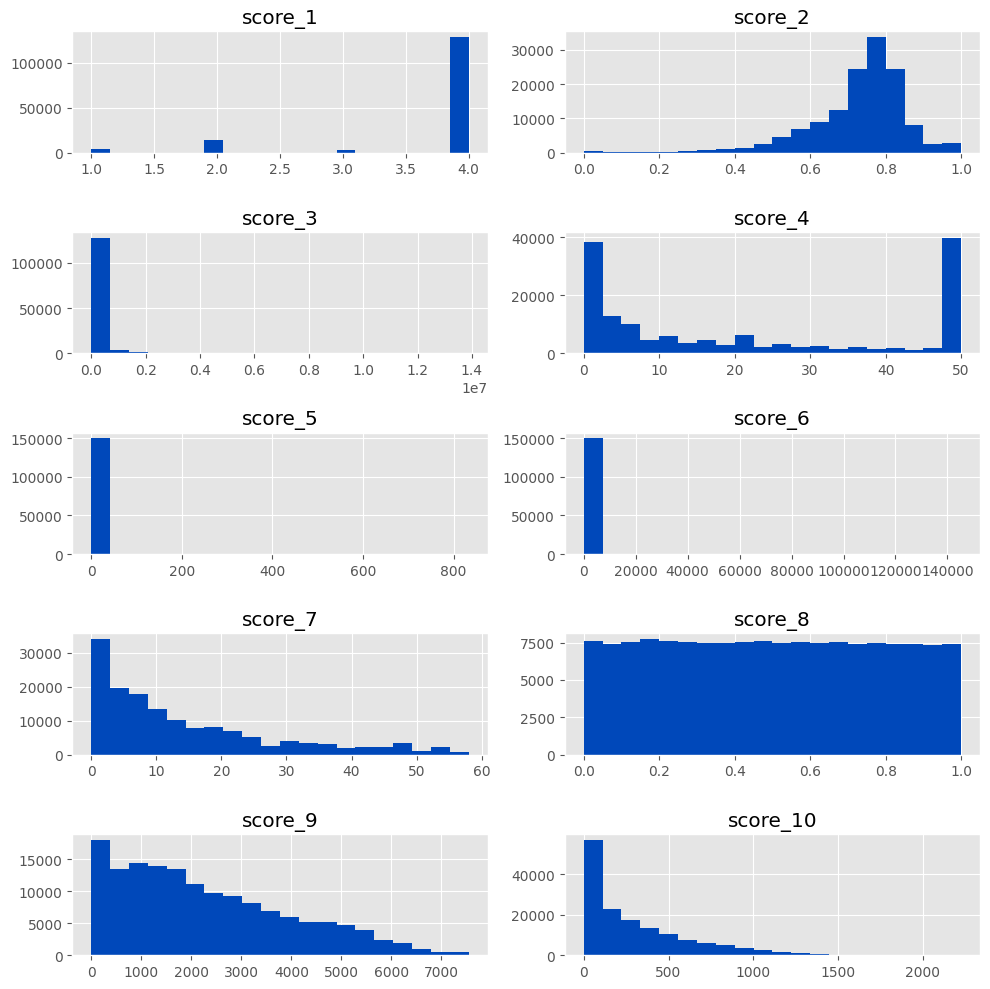

In [7]:
fig, axes = plt.subplots(5, 2, figsize=(10, 10))

cols = ["score_1", "score_2", "score_3", "score_4", 'score_5',
        'score_6', 'score_7', 'score_8', 'score_9', 'score_10']

# Loop para plotar os histogramas em cada subplot
for i, ax in enumerate(axes.ravel()):
    if i < len(cols):
        col = cols[i]
        ax.hist(data[col], bins=20, color=palette[0])  # Você pode ajustar o número de bins conforme necessário
        ax.set_title(col)
plt.tight_layout()

# Exibir os gráficos
plt.show()

> Podemos observar alguns padrões de outliers nos scores 3, 5 e 6.

> Porém, como não temos informação sobre os dados, optamos por não removermos essas informações. Ao invés disso, utilizaremos modelos de árvores de decisão, que são menos sensíveis a esses valores.

Podemos plotar a distribuição da variável valor_compra.

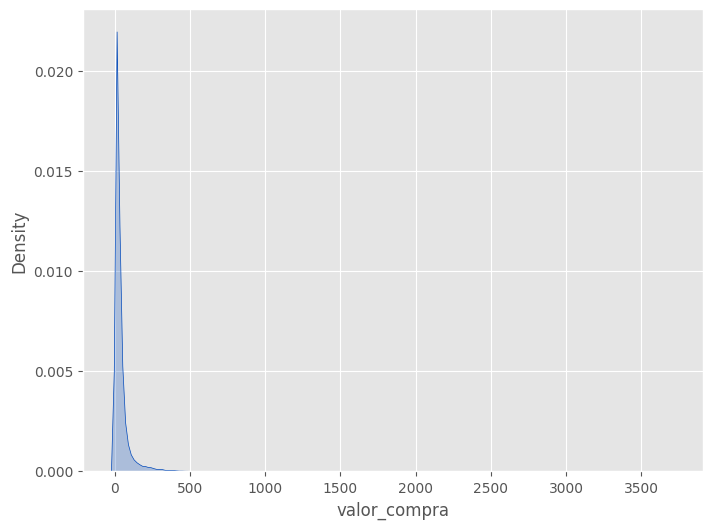

In [8]:
fig = plt.figure(figsize=(8,6))
sns.kdeplot(data['valor_compra'], fill=True, color=palette[0]);

> Podemos observar uma distribuição de cauda longa, com grande assimetria à direita.

## Análise Multivariada

Vamos observar se o valor da compra possui alguma relação com a fraude.

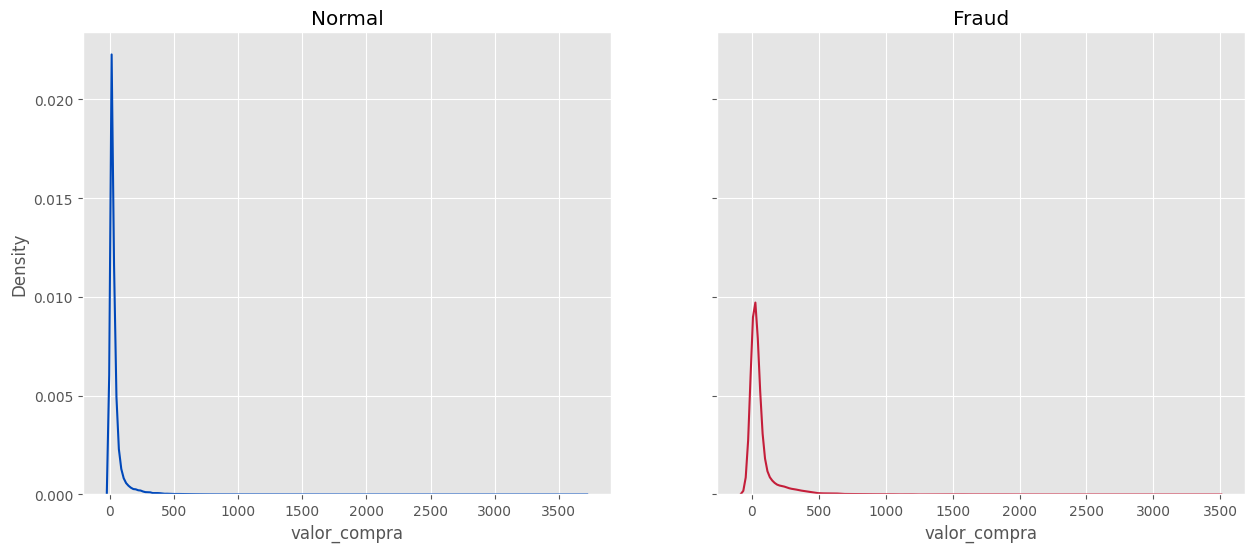

In [9]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6), sharey=True)
ax1 = sns.kdeplot(x='valor_compra', data=data[data["fraude"] == 0], ax=ax1, color=palette[0])

ax2 = sns.kdeplot(x='valor_compra',  data=data[data["fraude"] == 1], ax=ax2, color=palette[1])
ax1.set_title("Normal")
ax2.set_title("Fraud");

> Pode-se observar que transações normais possuem uma distribuição com um pico maior em valores baixos, enquanto operações fraudulentas são mais distribuidas ao longo de valores mais altos.

Vamos observar se as features de score possuem alguma relação com a target.

* Score 1

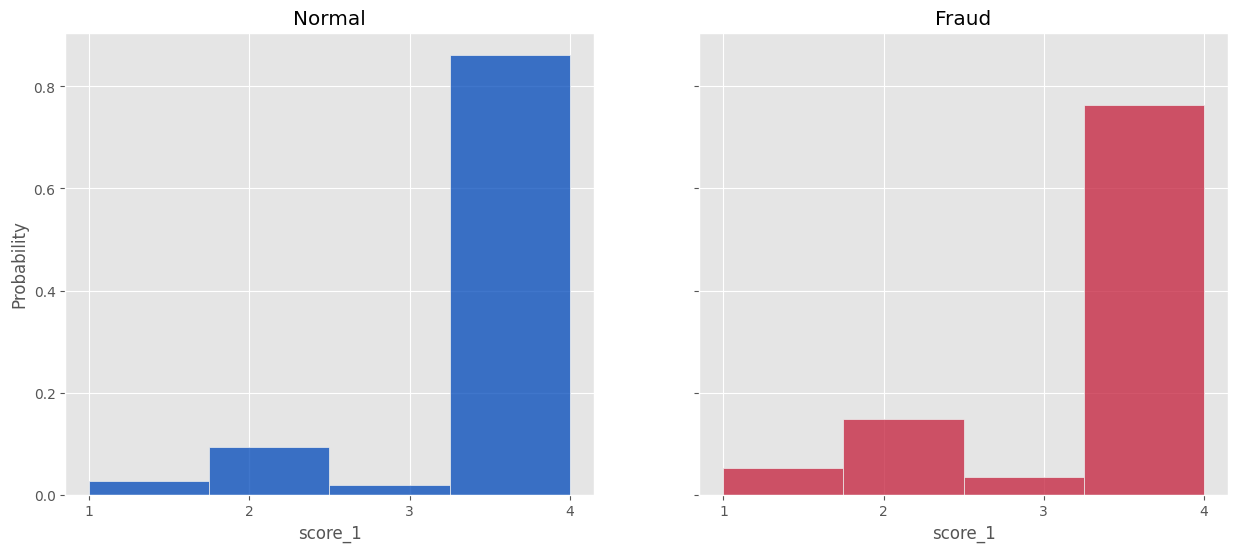

In [10]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6), sharey=True)
ax1 = sns.histplot(x='score_1', data=data[data["fraude"] == 0],
                   stat="probability", bins=4, ax=ax1, color = palette[0])
ax2 = sns.histplot(x='score_1', data=data[data["fraude"] == 1],
                   stat="probability", bins=4, ax=ax2, color = palette[1])
ax1.set_xticks([1,2,3,4])
ax2.set_xticks([1,2,3,4])
ax1.set_title("Normal")
ax2.set_title("Fraud");

> Podemos observar um pequeno aumento na proporção de transações normais quando o score é maior.

* Score 2

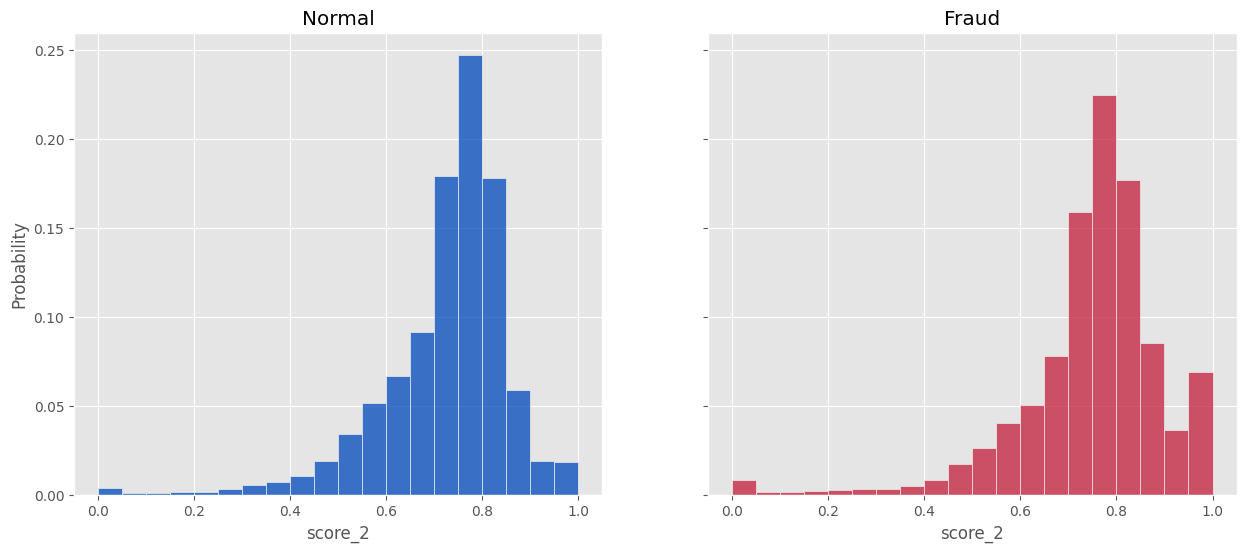

In [11]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6), sharey=True)
ax1 = sns.histplot(x='score_2', data=data[data["fraude"] == 0],
                   stat="probability", bins=20, ax=ax1, color = palette[0])
ax2 = sns.histplot(x='score_2', data=data[data["fraude"] == 1],
                   stat="probability", bins=20, ax=ax2, color = palette[1])

ax1.set_title("Normal")
ax2.set_title("Fraud");

> Para o score 2, a proporção de fraude aumenta um pouco quando está próximo de 1.

* Para analisarmos o score 3, iremos aplicar uma transformação logarítmica, que irá encurtar o intervalo de valores muito altos.

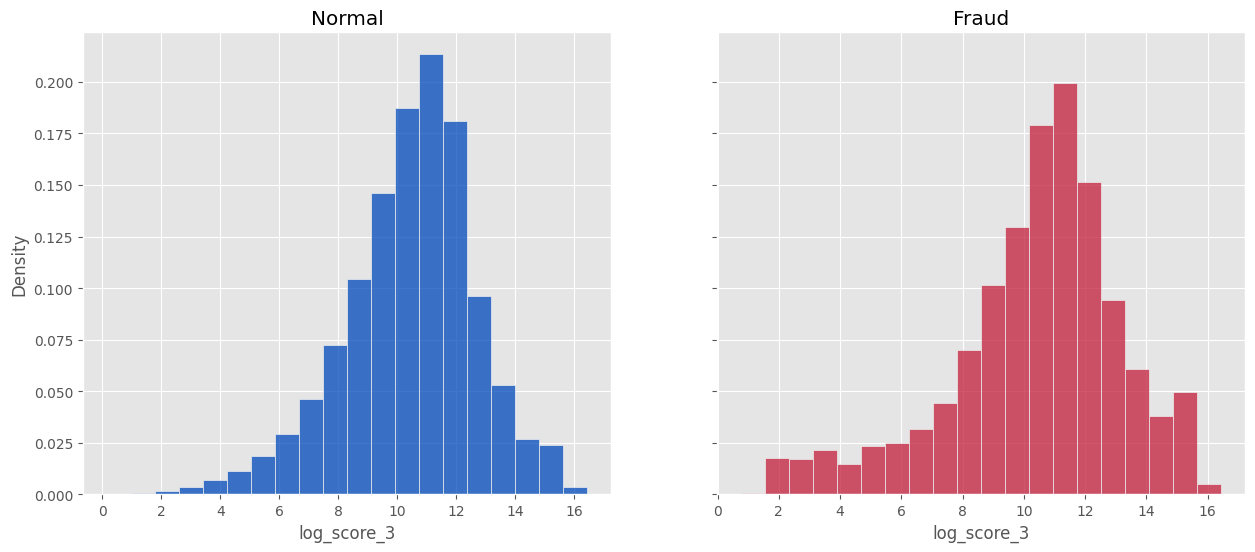

In [12]:
data['log_score_3'] = np.log1p(data['score_3'])

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6), sharey=True)
ax1 = sns.histplot(x='log_score_3', data=data[data["fraude"] == 0],
                   stat="density", bins=20, ax=ax1, color = palette[0])
ax2 = sns.histplot(x='log_score_3', data=data[data["fraude"] == 1],
                   stat="density", bins=20, ax=ax2, color = palette[1])

ax1.set_title("Normal")
ax2.set_title("Fraud");

> Pode-se observar também uma proporção transações fraudulentas maiores em scores baixos, comparados à transações normais.

* Score 4

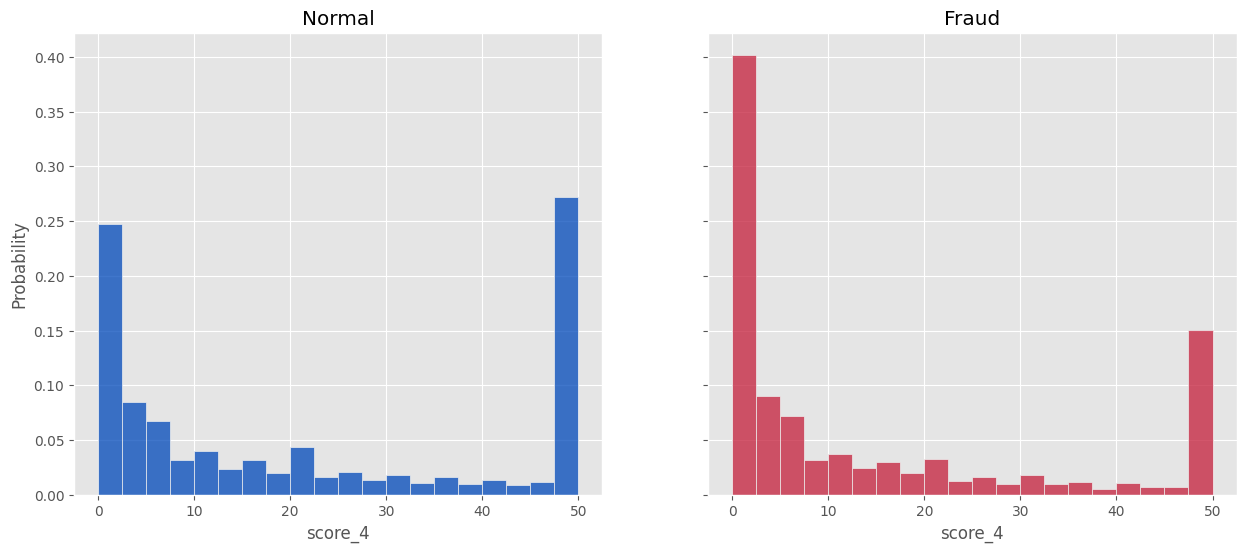

In [13]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6), sharey=True)
ax1 = sns.histplot(x='score_4', data=data[data["fraude"] == 0],
                   stat="probability", bins=20, ax=ax1, color = palette[0])
ax2 = sns.histplot(x='score_4', data=data[data["fraude"] == 1],
                   stat="probability", bins=20, ax=ax2, color = palette[1])

ax1.set_title("Normal")
ax2.set_title("Fraud");

> Podemos notar que a proporção de scores próximos a 0 em casos de fraude é consideravelmente maior do que em não fraudes.

* Por conta de valores muito altos no score 5, iremos plotar apenas os dados com percentis menores que 99.

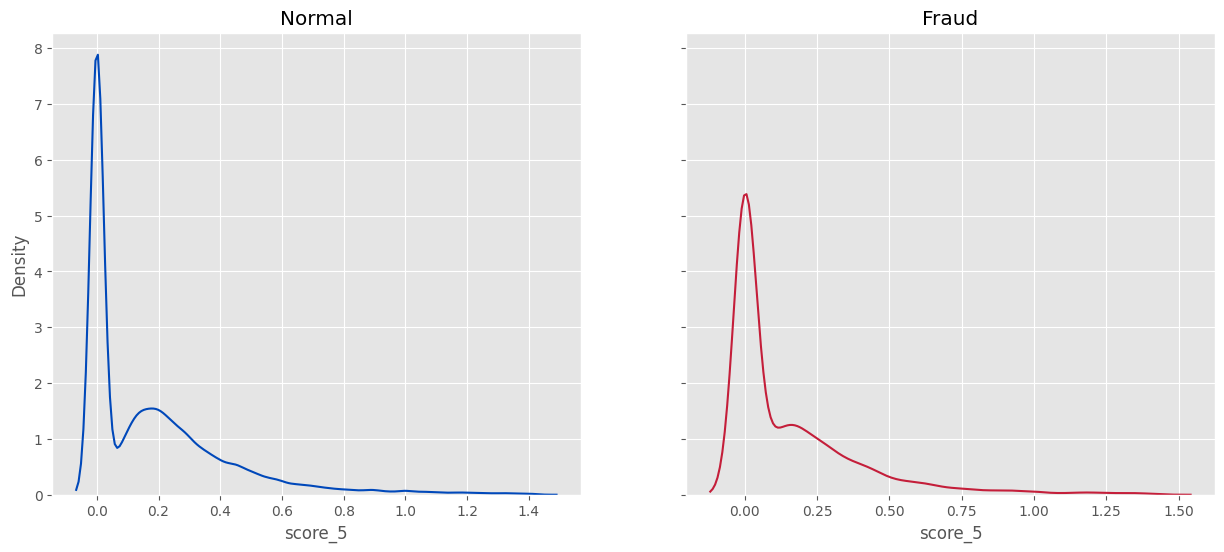

In [14]:
p99 = np.percentile(data['score_5'], 99)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6), sharey=True)
ax1 = sns.kdeplot(x='score_5', data=data[(data['score_5'] <p99) & (
                    data["fraude"] == 0)], ax=ax1, color=palette[0])

ax2 = sns.kdeplot(x='score_5', data=data[(data['score_5'] < p99) & (
                    data["fraude"] == 1)], ax=ax2, color=palette[1])
ax1.set_title("Normal")
ax2.set_title("Fraud");

> Podemos observar que, em transações normais, temos uma proporção maior de scores baixos, quando comparados a transações fraudulentas.

* Realizaremos o mesmo procedimento para o score 6.

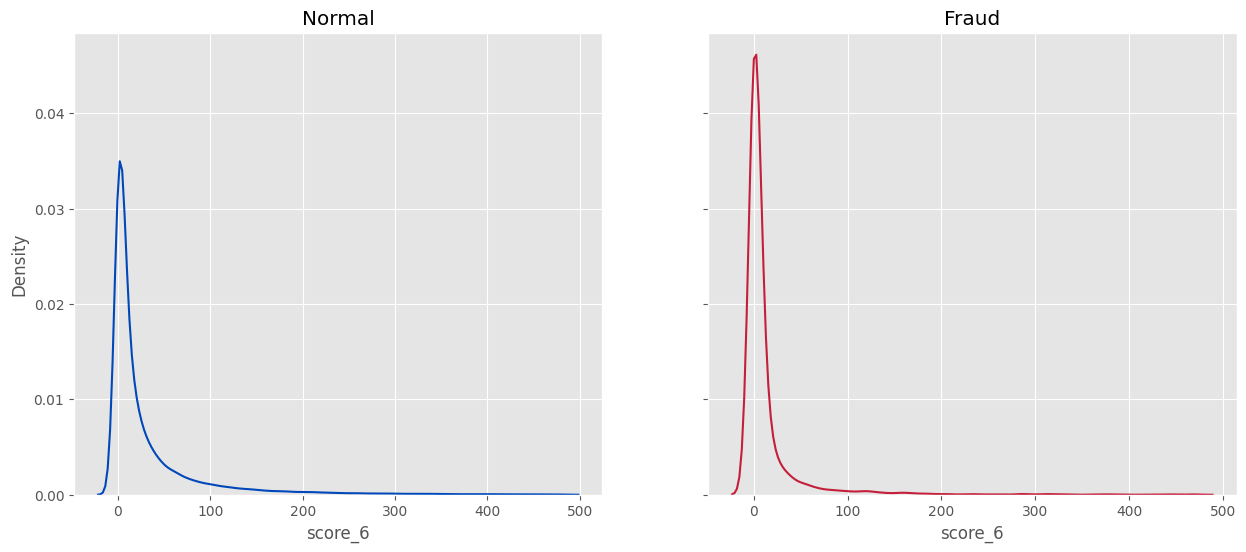

In [15]:
p99 = np.percentile(data['score_6'].dropna(), 99)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6), sharey=True)
ax1 = sns.kdeplot(x='score_6', data=data[(data['score_6'] < p99) & (
                    data["fraude"] == 0)], ax=ax1, color=palette[0])

ax2 = sns.kdeplot(x='score_6', data=data[(data['score_6'] < p99) & (
                    data["fraude"] == 1)], ax=ax2, color=palette[1])
ax1.set_title("Normal")
ax2.set_title("Fraud");

> Aqui notamos o inverso, há uma maior concentração em scores próximos a 0 em operações com fraude.

* Score 7

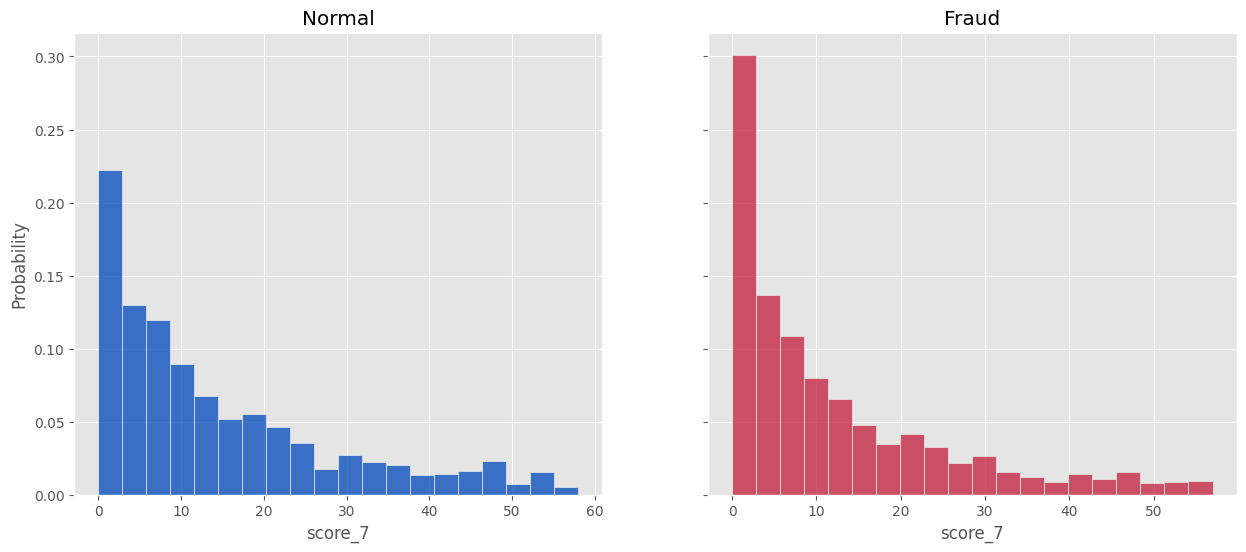

In [16]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6), sharey=True)
ax1 = sns.histplot(x='score_7', data=data[data["fraude"] == 0],
                   stat="probability", bins=20, ax=ax1, color = palette[0])
ax2 = sns.histplot(x='score_7', data=data[data["fraude"] == 1],
                   stat="probability", bins=20, ax=ax2, color = palette[1])

ax1.set_title("Normal")
ax2.set_title("Fraud");

> Observa-se também uma maior concentração em scores próximo a 0 para operações com fraude.

* Score 8

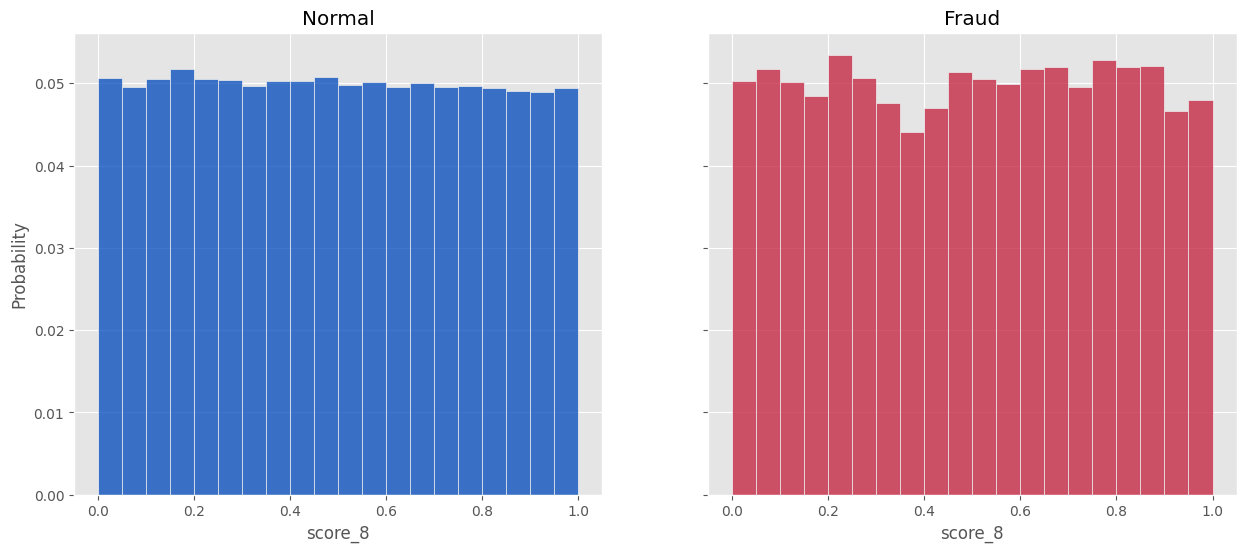

In [17]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6), sharey=True)
ax1 = sns.histplot(x='score_8', data=data[data["fraude"] == 0],
                   stat="probability", bins=20, ax=ax1, color = palette[0])
ax2 = sns.histplot(x='score_8', data=data[data["fraude"] == 1],
                   stat="probability", bins=20, ax=ax2, color = palette[1])

ax1.set_title("Normal")
ax2.set_title("Fraud");

> Para o score 8, podemos observar uma distribuição uniforme, sem muitas diferenças para operações fraudulentas e normais.

* Score 9

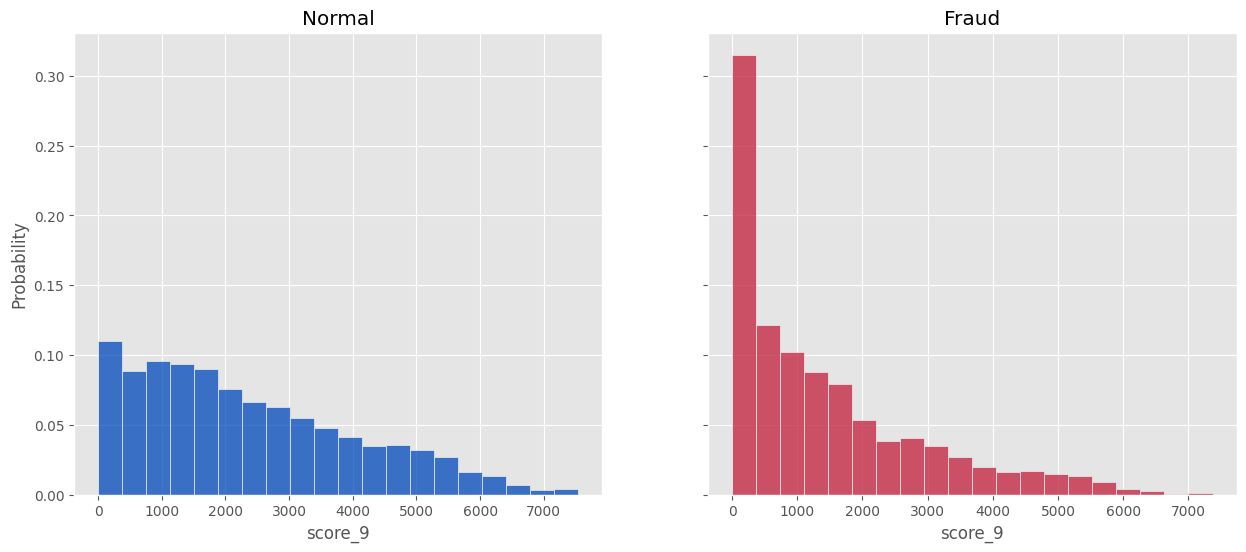

In [18]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6), sharey=True)
ax1 = sns.histplot(x='score_9', data=data[data["fraude"] == 0],
                   stat="probability", bins=20, ax=ax1, color = palette[0])
ax2 = sns.histplot(x='score_9', data=data[data["fraude"] == 1],
                   stat="probability", bins=20, ax=ax2, color = palette[1])

ax1.set_title("Normal")
ax2.set_title("Fraud");

> Para o score 9, podemos observar que a proporção de scores próximos a 0 é muito maior em operações fraudulentas!

* Score 10

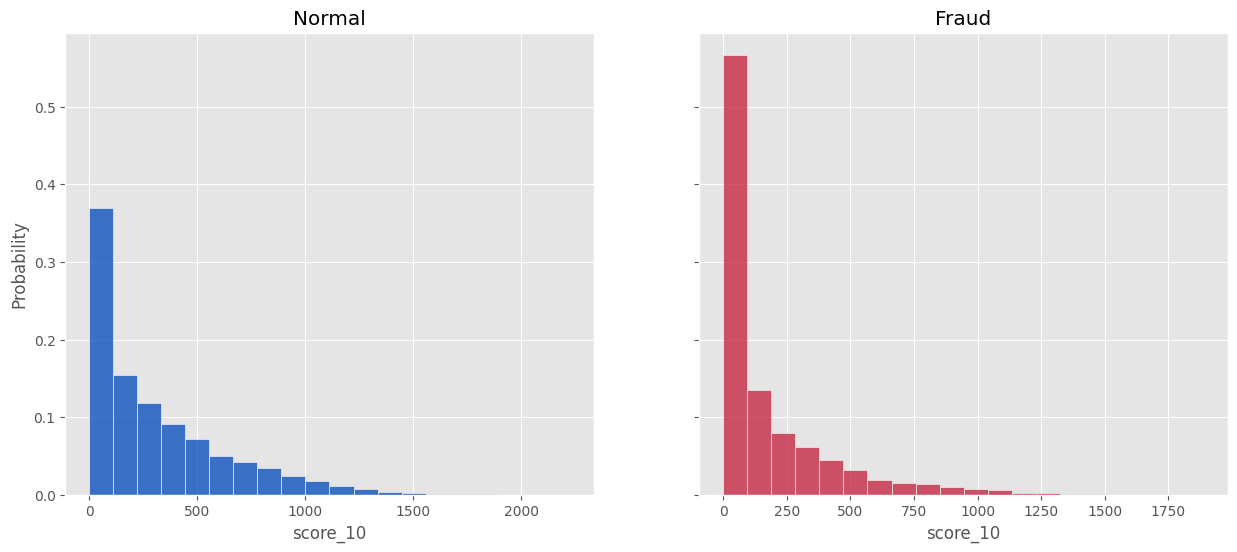

In [19]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6), sharey=True)
ax1 = sns.histplot(x='score_10', data=data[data["fraude"] == 0],
                   stat="probability", bins=20, ax=ax1, color = palette[0])
ax2 = sns.histplot(x='score_10', data=data[data["fraude"] == 1],
                   stat="probability", bins=20, ax=ax2, color = palette[1])

ax1.set_title("Normal")
ax2.set_title("Fraud");

> Assim como o score 9, o score 10 também nota-se uma discrepância alta para scores baixos.

Também podemos analisar se o horário da compra possui alguma relação com a fraude.

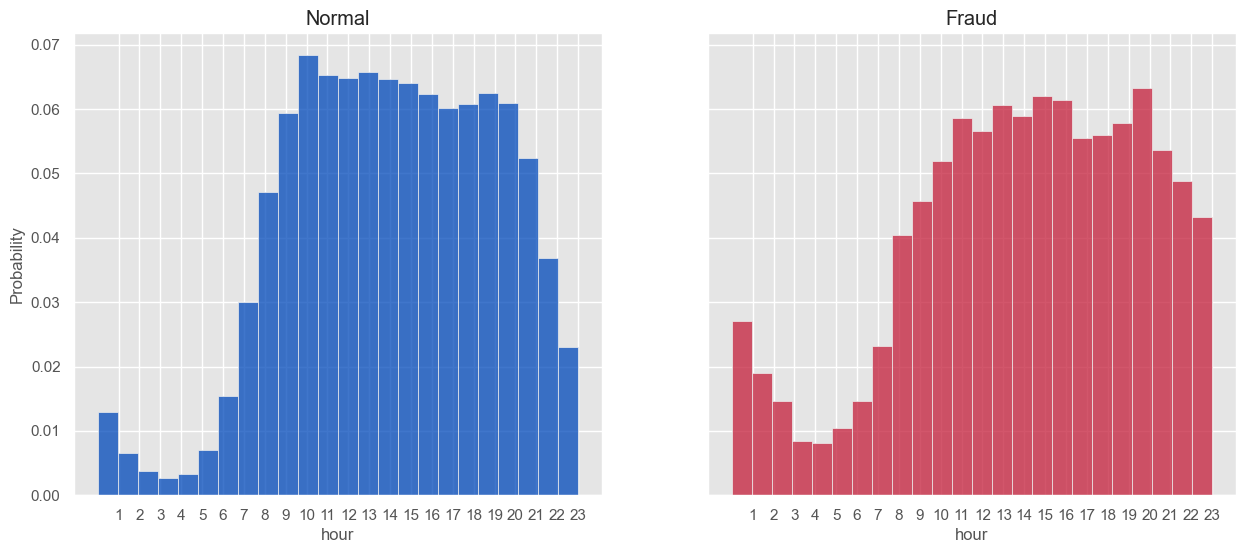

In [126]:
data['hour'] = pd.to_datetime(data['data_compra']).dt.hour
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6), sharey=True)
ax1 = sns.histplot(x='hour', data=data[data["fraude"] == 0],
                   stat="probability", bins=24, ax=ax1, color=palette[0])
ax2 = sns.histplot(x='hour', data=data[data["fraude"] == 1],
                   stat="probability", bins=24, ax=ax2, color= palette[1])
ax1.set_title("Normal")
ax2.set_title("Fraud")
ax1.set_xticks(np.arange(1, 24))
ax2.set_xticks(np.arange(1, 24));

> Pode-se notar que há uma proporção de fraudes maior em horários de madrugada, em comparação à transações normais.

Agora iremos plotar uma matriz de correlação entre as variáveis numéricas.

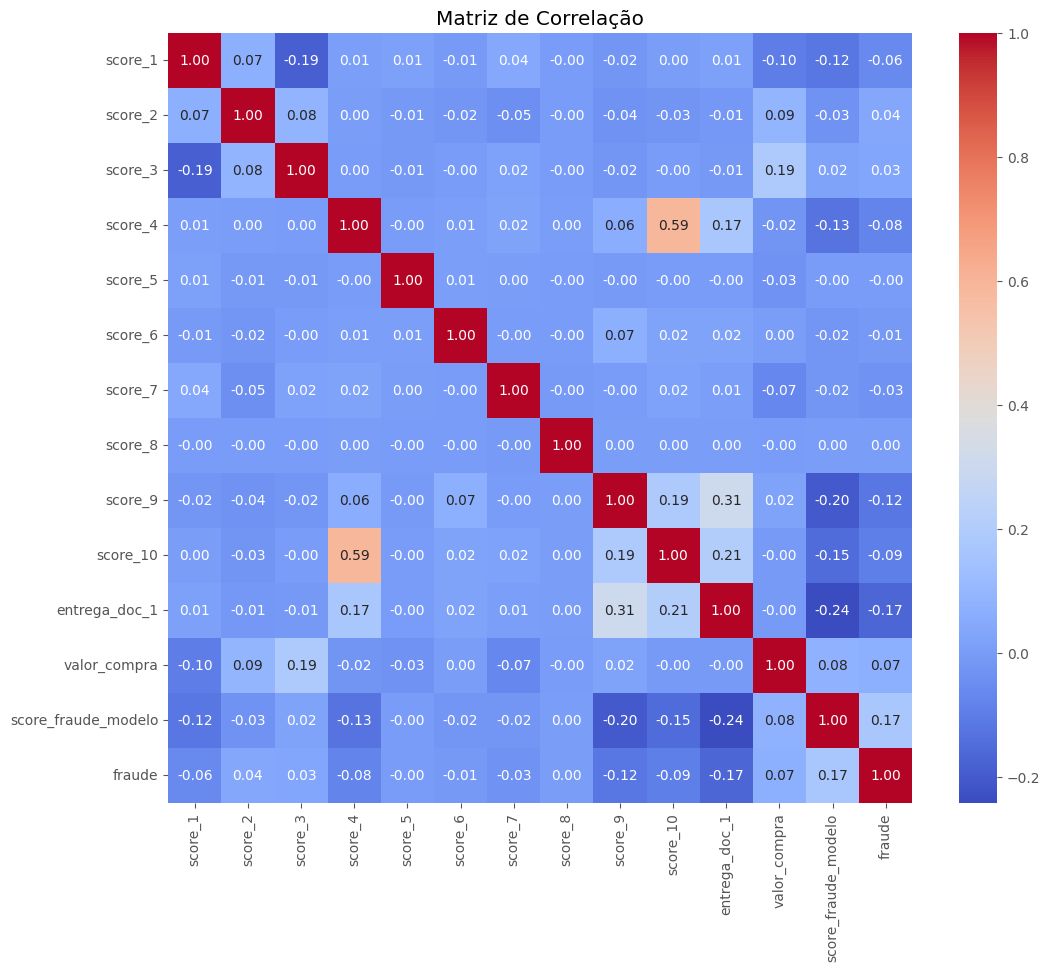

In [21]:
# removendo as colunas que criamos ao longo do EDA
data.drop(columns='hour', inplace=True)
data.drop(columns=['log_score_3'], inplace=True)

correlation_matrix = data.corr(numeric_only=True)
plt.figure(figsize=(12, 10))

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")

plt.title("Matriz de Correlação")
plt.show()

# Data splitting

Vamos separar nosso dataset em treino e teste.

In [22]:
X = data.drop(columns=['fraude'])
y = data['fraude']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=0, test_size=0.2, stratify=y)

# Data pre-processing

## Missing Data

Devemos analisar cuidadosamente cada variável e os significados de seus valores estarem faltantes, para decidir o tipo de imputação.

In [23]:
data.isnull().sum().sort_values(ascending=False)

entrega_doc_2          108857
score_3                 12984
score_2                 12984
score_4                   365
score_10                  365
pais                      194
score_6                    11
score_9                    11
score_1                     0
score_fraude_modelo         0
valor_compra                0
data_compra                 0
entrega_doc_3               0
score_8                     0
entrega_doc_1               0
categoria_produto           0
produto                     0
score_7                     0
score_5                     0
fraude                      0
dtype: int64

Para a variável "entrega_doc_2", iremos considerar como "N" os valores faltantes, ou seja, não entregue.

In [24]:
replace_N = ['entrega_doc_2']
imputer_N = imputation.CategoricalImputer(fill_value='N', variables=replace_N)

Para as features de score, iremos atribuir a mediana dos valores, pelo fato de não seguirem uma distribuição normal.

In [25]:
replace_median = ['score_2', 'score_3',
                  'score_4', 'score_6',
                  'score_9', 'score_10']

imputer_median = imputation.MeanMedianImputer(imputation_method='median', variables= replace_median)

Para a feature "pais", iremos atribuir o valor "XX", ou seja, um país desconhecido.

In [26]:
replace_x = ['pais']
imputer_x = imputation.CategoricalImputer(fill_value='XX', variables=replace_x)

Iremos criar também uma função que crie uma coluna para cada coluna que possui valor missing no dataset, e indique quais linhas possuem missing.

In [27]:
# Função para criar colunas de indicadores de missing values
def create_missing_indicator_columns(X):
    missing_indicator_columns = pd.DataFrame()
    for column in X.columns:
        if X[column].isnull().any():
            missing_indicator = X[column].isnull().astype(int)
            missing_indicator_columns[f'is_missing_{column}'] = missing_indicator

    return pd.concat([X, missing_indicator_columns], axis=1)

# Criando um FunctionTransformer para a função
missing_indicator_transformer = FunctionTransformer(create_missing_indicator_columns, validate=False)

# Feature Engineering

Para as categorias "pais" e "categoria_produto", iremos aplicar a técnica WOE (Weight of Evidence). O cálculo do WOE é calculado pelo ln da proporção de eventos dividido pela proporção de não eventos de cada classe, ilustrado abaixo.

<img src="../../static/woe_formula.png" style="height: 130px;"/>

In [28]:
class WOEEncoderTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, cols=None):
        self.encoder = WOEEncoder(cols=cols)

    def fit(self, X, y=None):
        self.encoder.fit(X, y)
        return self

    def transform(self, X):
        X_encoded = self.encoder.transform(X)
        return X_encoded

Precisamos também transformar as colunas "entrega_doc_2" e "entrega_doc_3" em binárias.

In [29]:
class BinaryLabelEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_copy = X.copy()
        for column in self.columns:
            X_copy[column] = X_copy[column].map({'Y': 1, 'N': 0})
        return X_copy
    
columns_to_encode = ['entrega_doc_2', 'entrega_doc_3']

label_encoder = BinaryLabelEncoder(columns=columns_to_encode)

Também iremos extrair a informação de hora da coluna "data_compra"

In [30]:
date_variable = ['data_compra']

hour_extractor = DatetimeFeatures(variables=date_variable, features_to_extract=['hour'])

Por fim, precisamos remover as features categóricas que realizamos o categorical encoding.

* produto: Iremos remover essa feature pois se trata de uma categórica de cardinalidade muito alta. Logo, podemos considerar como se fosse um ID do produto.

* score_fraude_modelo: Como se trata do score do modelo implantado atualmente, em um primeiro momento, optaremos por retirar essa informação do modelo, pois estamos supondo que não teremos acesso a essa informação caso o modelo seja substituido, ou seja, estaríamos gerando vazamento de dados.

In [31]:
columns_to_remove = ['produto', 'score_fraude_modelo']

drop_features = DropFeatures(features_to_drop=columns_to_remove)

# Modeling

## Model Training

Iremos utilizar o MLflow para monitorar nosso modelo. Com isso, conseguimos testar diversos modelos e realizar a comparação dos modelos.

In [32]:
mlflow.set_experiment(experiment_name='fraud_modeling')

mlflow.sklearn.autolog()

In [33]:
%%capture
with mlflow.start_run(run_name='LGBM Tuned_2 scale_pos_weight'):

    ratio = float(y_train.value_counts()[0]) / y_train.value_counts()[1]
    model = LGBMClassifier(scale_pos_weight= ratio,random_state=0)
    # espaço dos parâmetros do LGBM a serem tunados
    space_lgbm = {'learning_rate': (0.035, 0.065),
                'num_leaves': (20,40),
                'min_child_samples': (20,40),
                'subsample': (0.25, 0.55),
                'colsample_bytree': (0.35, 0.65),
                'max_depth': (12,16)
                }

    space_rf = {'n_estimators': (50, 200),
                'max_features': ('auto', 'sqrt', 'log2'),
                'max_depth': (3, 20),
                'min_samples_leaf': (20, 150),
                }

    # tunagem dos hiperparâmetros utilizando busca bayesiana
    bayes_search = BayesSearchCV(model, space_lgbm, cv=5, scoring='roc_auc',
                                 n_iter= 20, verbose=100, random_state=0)

    # aqui juntamos todos os steps em um único pipeline
    # dessa forma, conseguimos garantir que os dados de treino e teste passem exatamente pelas mesmas transformações

    pipeline = Pipeline([
                         ('missing_indicator', missing_indicator_transformer),
                         ('imputer_N', imputer_N),
                         ('imputer_median', imputer_median),
                         ('imputer_x', imputer_x),
                         ('WOE Encoder', WOEEncoderTransformer(cols=['categoria_produto','pais'])),
                         ('label_encoder', label_encoder),
                         ('hour_extractor', hour_extractor),
                         ('drop_features', drop_features),
                         ('model', bayes_search)
                        ])
    # treinando o modelo
    pipeline.fit(X_train, y_train)
    
    # metricas de treino
    y_train_pred = pipeline.predict(X_train)
    y_train_score = pipeline.predict_proba(X_train)[:, 1]

    train_accuracy = metrics.accuracy_score(y_train, y_train_pred)
    train_precision = metrics.precision_score(y_train, y_train_pred)
    train_recall = metrics.recall_score(y_train, y_train_pred)
    train_f1_score = metrics.f1_score(y_train, y_train_pred)
    train_auc = metrics.roc_auc_score(y_train, y_train_score)
    train_log_loss = metrics.log_loss(y_train, y_train_score)
    
    # metricas de teste
    y_test_pred = pipeline.predict(X_test)
    y_test_score = pipeline.predict_proba(X_test)[:, 1]
    
    test_accuracy = metrics.accuracy_score(y_test, y_test_pred)
    test_precision = metrics.precision_score(y_test, y_test_pred)
    test_recall = metrics.recall_score(y_test, y_test_pred)
    test_f1_score = metrics.f1_score(y_test, y_test_pred)
    test_auc = metrics.roc_auc_score(y_test, y_test_score)
    test_log_loss = metrics.log_loss(y_test, y_test_score)
    
    model_metrics = {"accuracy_train": train_accuracy,
                    "accuracy_test": test_accuracy,
                    "precision_train": train_precision,
                    "precision_test": test_precision,
                    "recall_train": train_recall,
                    "recall_test": test_recall,
                    "f1_score_train": train_f1_score,
                    "f1_score_test": test_f1_score,
                    "auc_train": train_auc,
                    "auc_test": test_auc,
                    "log_loss_train": train_log_loss,
                    "log_loss_test": test_log_loss
                    }
    
    mlflow.log_metrics(model_metrics)
    mlflow.sklearn.log_model(model, "lgbm")

Resultados do MLflow:

<img src="../../static/mlflow.png" style="height: 300px;"/>

<img src="../../static/mlflow_auc_train_test.png" style="height: 400px;"/>

> Após diversos algoritmos testados, foi observada uma performance melhor nos algoritmos LGBM e Random Forest.

> Com isso, foi realizada a tunagem dos hiperparâmetros dos modelos LGBM e Random Forest, com a finalidade de aproximar o AUC entre treino e teste dos modelos. Isso indica uma boa capacidade de generalização do modelo.

> Também foi utilizado o parâmetro scale_pos_weight no algoritmo LGBM para tratar o desbalanceamento dos dados.

> Por fim, foi escolhido o modelo "LGBM Tuned_2 scale_pos_weight".

## Otimização do ponto de corte

Para otimizar o ponto de corte, iremos utilizar a informação do case, que diz que a empresa recebe 10% de comissão por transações aprovadas, e tem a perda de 100% do valor em caso de uma fraude. Com isso, conseguimos otimizar o threshold baseado no lucro máximo da empresa.

* Com isso, criaremos uma função para calcular o threshold que otimiza o lucro da empresa.

In [34]:
def max_threshold(X_train, y_train_score):
    valor_compra = X_train['valor_compra'].values
    thresholds = np.linspace(0, 1, num=100)

    data = []
    profits = []

    best_threshold = 0
    max_value = 0
    for threshold in thresholds:
        true_negatives = (y_train_score < threshold) & (y_train == 0)
        false_negatives = (y_train_score < threshold) & (y_train == 1)

        revenue = np.sum(0.1 * (true_negatives * valor_compra))
        loss = np.sum(false_negatives * valor_compra)

        profit = revenue - loss
        profits.append(profit)
        if profit > max_value:
            max_value = profit
            best_threshold = threshold
        data.append([threshold, revenue, loss, profit])
    return best_threshold

# Model Evaluation

Vamos criar uma função que nos ajude a avaliar o modelo.

In [112]:
def evaluate_model(valor_compra, target, y_score, threshold = 0.5):
    """"
    Função para gerar métricas de performance para o modelo.

    Parametros
    ----------
    valor_compra: 1d array
        vetor contendo o valor da compra realizada
    target: 1d array
        variável target
    y_score: 1d array
        vetor de scores gerado pelo modelo
    threshold: float or int
        valor de threshold a ser avaliado
    """
    
    predicted = y_score >= threshold
    accuracy = metrics.accuracy_score(target, predicted)
    precision = metrics.precision_score(target, predicted)
    recall = metrics.recall_score(target, predicted)
    f1 = metrics.f1_score(target, predicted)
    auc = metrics.roc_auc_score(target, y_score)

    confusion_matrix = metrics.confusion_matrix(
        target, predicted)
    cm_display = metrics.ConfusionMatrixDisplay(
        confusion_matrix=confusion_matrix, display_labels=[False, True])
    cm_display.plot()
    plt.grid(False)
    plt.show()

    true_negatives = (y_score < threshold) & (target == 0)
    false_negatives = (y_score < threshold) & (target == 1)

    revenue = np.sum(0.1 * (true_negatives * valor_compra.values))
    loss = np.sum(false_negatives * valor_compra.values)
    profit = revenue - loss

    approval_rate = (confusion_matrix[0][0] + confusion_matrix[1][0])/confusion_matrix.sum()
    fraud_rate = confusion_matrix[1][0]/(confusion_matrix[1][0]+confusion_matrix[0][0])

    fpr, tpr, threshold = metrics.roc_curve(target, y_score)
    plt.plot(fpr, tpr, label="Model", c="blue")
    plt.plot([0, 1], [0, 1], linestyle="--", c="yellow")
    plt.title("ROC Curve")
    plt.legend()
    plt.show()

    print("Accuracy", accuracy.round(2))
    print("Precision:", precision.round(2))
    print("Recall:", recall.round(2))
    print("F1 Score", f1.round(2))
    print("AUC:", auc)
    print(f"Profit:{profit:.2f}")
    print(f"Taxa de Aprovação: {approval_rate:.2f}")
    print(f"Taxa de Fraude: {fraud_rate:.3f}")
    return None

Criaremos agora uma função para plotar as distribuição dos scores para fraude e não fraude.

In [77]:
def score_distribution(target, y_score, ax=None):
    """
    Função para plotar a distribuição dos scores gerados pelo modelo para cada classe.

    Parametros
    ----------
    target: 1d array
        variável target
    y_score: 1d array
        vetor de scores gerado pelo modelo
    ax: objeto Axes, opcional
        O objeto Axes no qual o gráfico será desenhado. Se None, a função criará uma nova figura.

    Retorna
    -------
    ax: objeto Axes
        O objeto Axes onde o gráfico foi desenhado.
    """

    df = pd.DataFrame({'target': target, 'y_score': y_score})

    # Separar os dados com base no valor da classe de destino (0 ou 1)
    class_0 = df[df['target'] == 0]
    class_1 = df[df['target'] == 1]

    # Se ax não for fornecido, criar uma nova figura
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))
    
    sns.set(style="whitegrid")

    # Plotar o histograma das probabilidades para cada classe
    ax.hist(class_0['y_score'], bins=50, density=True, alpha=0.5, label='0', color=palette[0])
    ax.hist(class_1['y_score'], bins=50, density=True, alpha=0.5, label='1', color=palette[1])

    # Plotar as distribuições das probabilidades para cada classe (KDE)
    sns.kdeplot(class_0['y_score'], fill=False, color=palette[0], ax=ax)
    sns.kdeplot(class_1['y_score'], fill=False, color=palette[1], ax=ax)

    # Adicionar rótulos e legenda
    ax.set_xlim([0, 1])
    ax.set_xlabel('Scores')
    ax.set_ylabel('Density')
    ax.set_title('Score Distribution')
    ax.legend()

    return ax


Por fim, criamos uma função para plotar a métrica de lucro para cada threshold

In [127]:
def plot_profits(X, target, y_score, ax=None):
    """
    Função para plotar a distribuição dos scores gerados pelo modelo para cada classe.

    Parametros
    ----------
    X: array
        matriz de treino
    y_score: 1d array
        vetor de scores gerado pelo modelo
    ax: objeto Axes, opcional
        O objeto Axes no qual o gráfico será desenhado. Se None, a função criará uma nova figura.

    Retorna
    -------
    ax: objeto Axes
        O objeto Axes onde o gráfico foi desenhado.
    """

    valor_compra = X['valor_compra'].values
    thresholds = np.linspace(0, 1, num=100)

    profits = []
    best_threshold = 0
    max_value = 0

    for threshold in thresholds:
        true_negatives = (y_score < threshold) & (target == 0)
        false_negatives = (y_score < threshold) & (target == 1)

        revenue = np.sum(0.1 * (true_negatives * valor_compra))
        loss = np.sum(false_negatives * valor_compra)

        profit = revenue - loss
        profits.append(profit)

    if ax is None:
        fig, ax = plt.subplots()
    
    sns.scatterplot(x=thresholds, y=profits, ax=ax, color=palette[0])
    ax.set_xlabel('Thresholds')
    ax.set_ylabel('Profits')
    return ax

## Modelo Novo

Vamos avaliar as métricas do modelo novo no conjunto de treino para um threshold padrão (0.5):

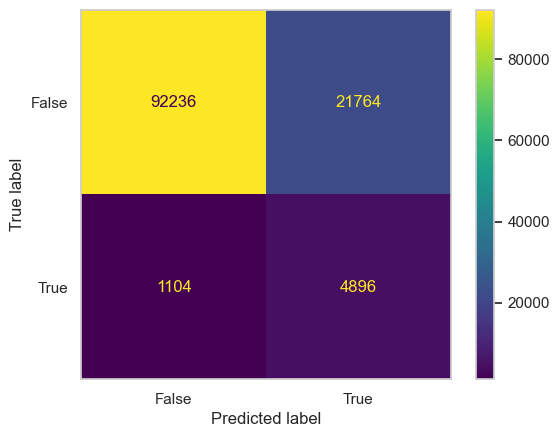

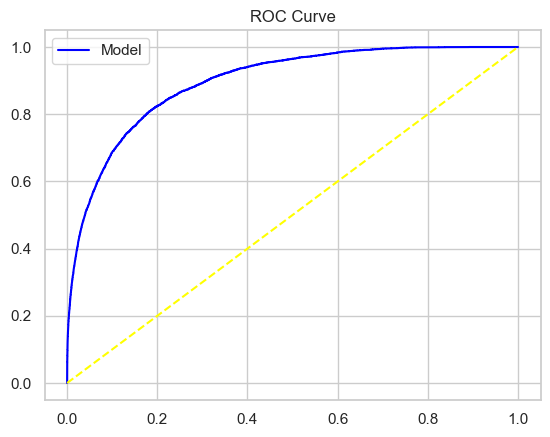

Accuracy 0.81
Precision: 0.18
Recall: 0.82
F1 Score 0.3
AUC: 0.8966237280701754
Profit:300328.60
Taxa de Aprovação: 0.78
Taxa de Fraude: 0.012


In [113]:
evaluate_model(X_train['valor_compra'], y_train, y_train_score)

> Como observado, com um threshold de 0.5, foi gerado um lucro de $300.328 para a empresa, com uma taxa de aprovação de 0.78 e uma taxa de fraude de 0.012 com o novo modelo.

Agora iremos avaliar o modelo considerando o ponto ótimo de corte

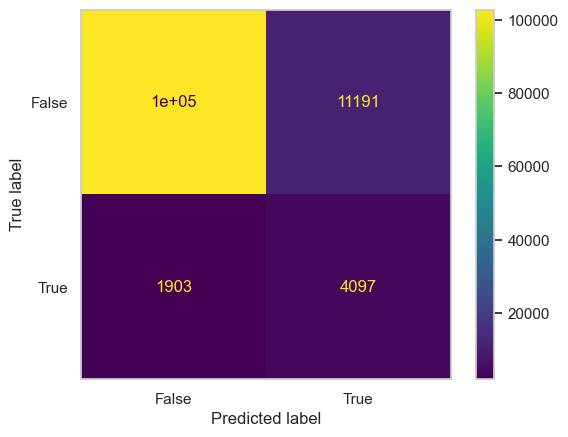

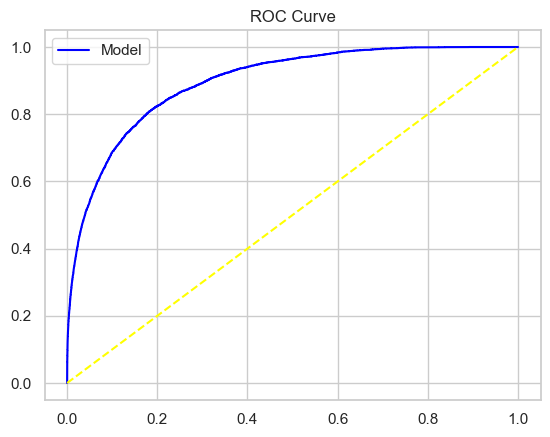

Accuracy 0.89
Precision: 0.27
Recall: 0.68
F1 Score 0.38
AUC: 0.8966237280701754
Profit:315242.93
Taxa de Aprovação: 0.87
Taxa de Fraude: 0.018


In [58]:
best_threshold = max_threshold(X_train, y_train_score)
evaluate_model(X_train['valor_compra'], y_train, y_train_score, threshold=best_threshold)

> Com a utilização do ponto de corte ótimo, o modelo gerou um lucro de $315.242 ou seja, $14.914 a mais do que com o ponto de corte padrão, com uma taxa de aprovação de 0.87 e taxa de fraude 0.18.

> Apesar da taxa de fraude ter aumentado em 0.06, temos uma taxa de aprovação maior, ou seja, menos problemas para a empresa em relação à clientes, e também temos um lucro gerado maior.

Podemos também avaliar as distribuições dos scores para cada classe

<Axes: title={'center': 'Score Distribution'}, xlabel='Scores', ylabel='Density'>

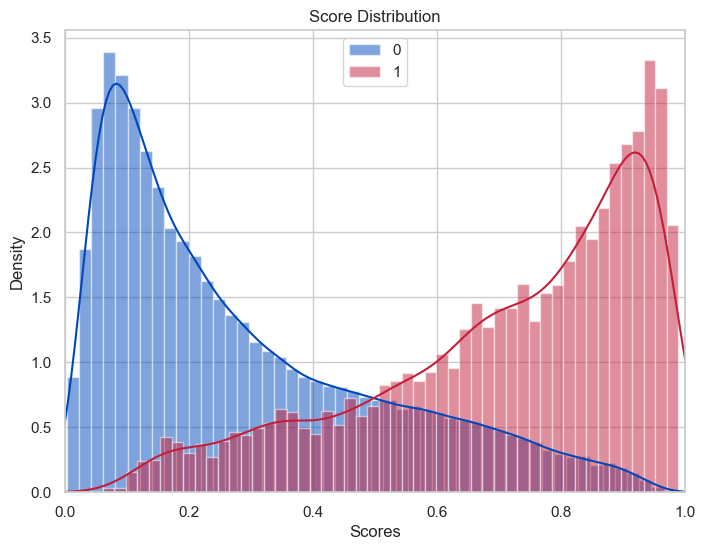

In [75]:
score_distribution(y_train, y_train_score)

Agora, iremos analisar a performance do modelo no conjunto de teste.

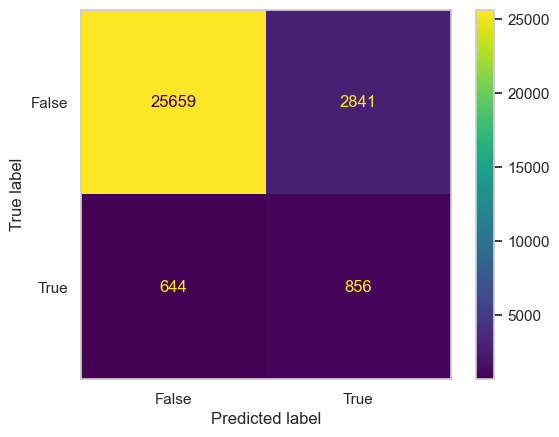

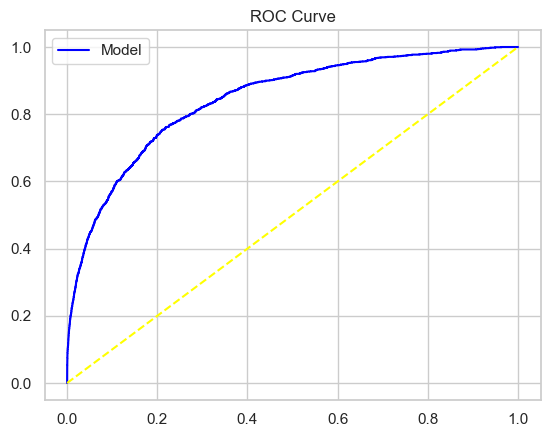

Accuracy 0.88
Precision: 0.23
Recall: 0.57
F1 Score 0.33
AUC: 0.845529730994152
Profit:66136.58
Taxa de Aprovação: 0.88
Taxa de Fraude: 0.024


In [52]:
evaluate_model(X_test['valor_compra'], y_test, y_test_score, threshold=best_threshold)

> Logo, no conjunto de teste, obtivemos um lucro de $66.136, uma taxa de aprovação de 0.88 e taxa de fraude 0.024.

Podemos também observar a distribuição dos scores no conjunto de teste.

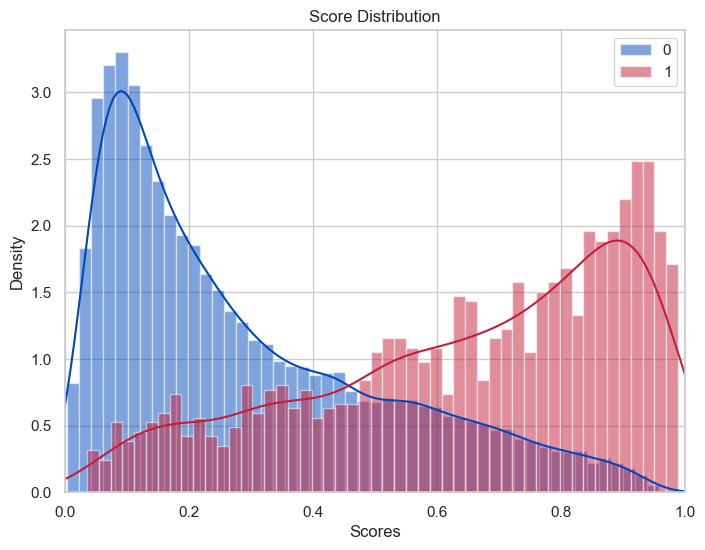

In [61]:
score_distribution(y_test, y_test_score)

## Modelo Atual

Agora, vamos avaliar a performance do modelo atual, baseado na coluna "score_fraude_modelo".

* A coluna varia de 0 a 100, ou seja, interpretamos como a probabilidade da transação ser fraudulenta.

In [53]:
# dividiremos a coluna por 100, para variar de 0 a 1 e conseguirmos avaliar as métricas.
y_train_score_modelo_atual = X_train["score_fraude_modelo"]/100
y_test_score_modelo_atual = X_test["score_fraude_modelo"]/100

Primeiro avaliaremos as métricas no conjunto de treino, no threshold padrão (0.5).

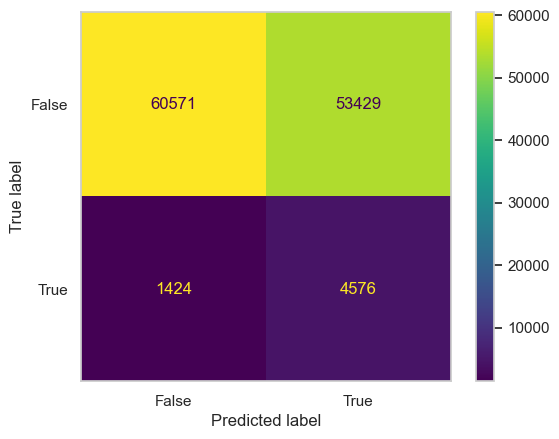

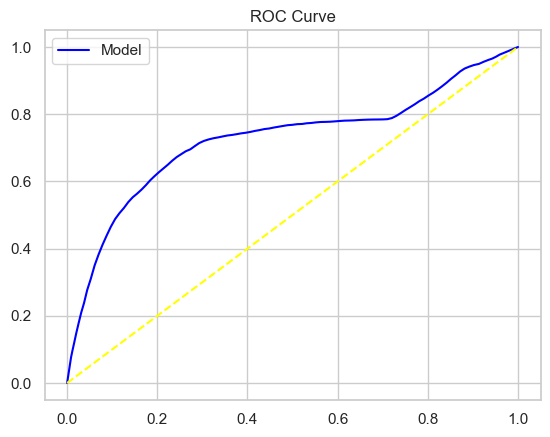

Accuracy 0.54
Precision: 0.08
Recall: 0.76
F1 Score 0.14
AUC: 0.7248102777777778
Profit:141711.77
Taxa de Aprovação: 0.52
Taxa de Fraude: 0.023


In [54]:
evaluate_model(X_train['valor_compra'], y_train, y_train_score_modelo_atual)

> Observe que temos um AUC de 0.72, um lucro de 141.711, com uma taxa de aprovação de apenas 0.52 e taxa de fraude 0.023.

Vamos observar a distribuição dos scores no conjunto de treino para o modelo atual.

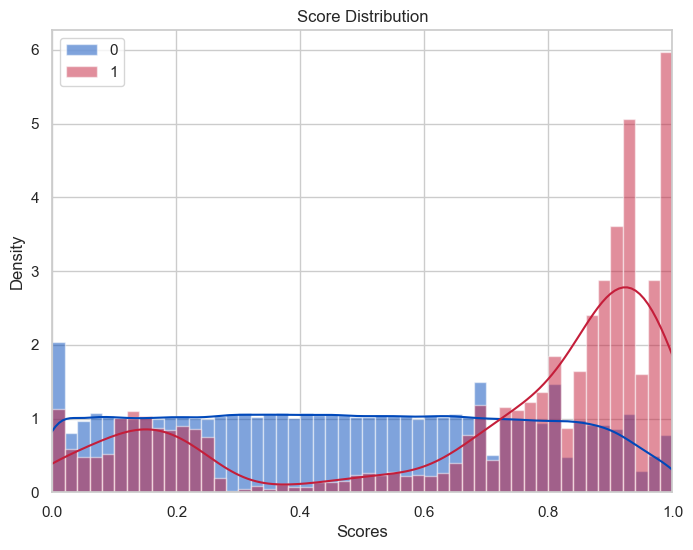

In [63]:
score_distribution(y_train, y_train_score_modelo_atual)

> Pode-se observar que o modelo atual não tem uma capacidade tão boa de separar o evento do não evento.

Agora iremos calcular o ponto de corte ideal para o modelo atual.

In [55]:
best_threshold_modelo_atual = max_threshold(X_train, y_train_score_modelo_atual)
best_threshold_modelo_atual

0.7575757575757577

> o Threshold que maximiza o lucro do modelo atual é de aproximadamente 0.75.

Vamos avaliar as métricas no conjunto de treino, porém com o threshold ótimo.

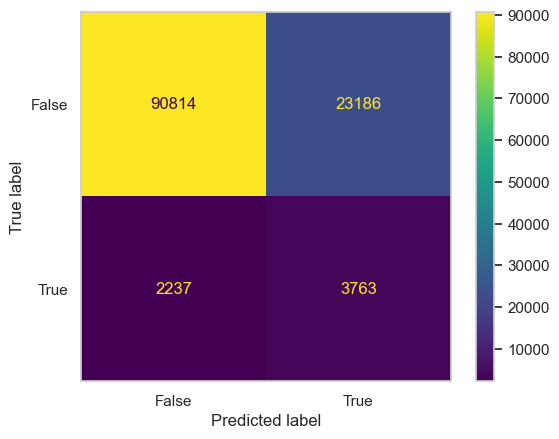

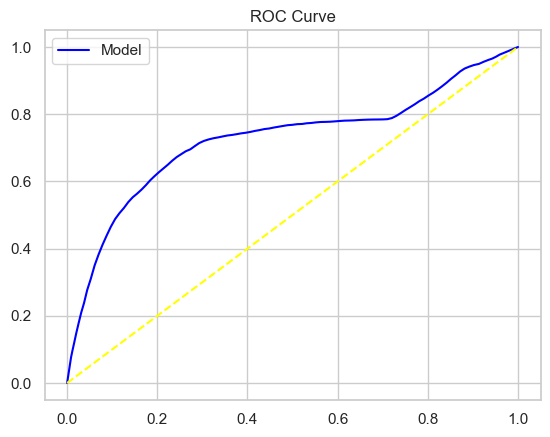

Accuracy 0.79
Precision: 0.14
Recall: 0.63
F1 Score 0.23
AUC: 0.7248102777777778
Profit:210971.88
Taxa de Aprovação: 0.78
Taxa de Fraude: 0.024


In [56]:
evaluate_model(X_train['valor_compra'], y_train, y_train_score_modelo_atual, threshold= best_threshold_modelo_atual)

> Portanto, com o threshold ótimo, temos um lucro de 210.971, com uma taxa de aprovação de 0.78 e taxa de fraude 0.024.

Podemos também avaliar a performance no conjunto de teste.

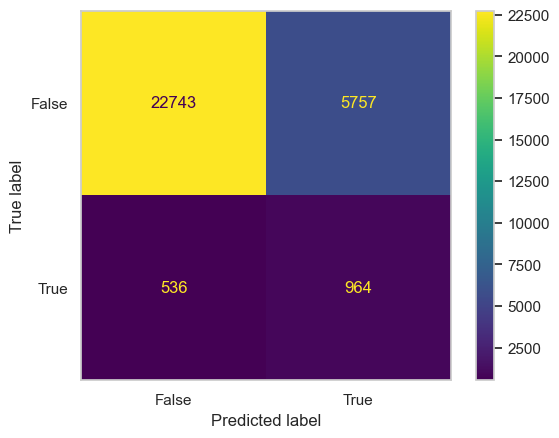

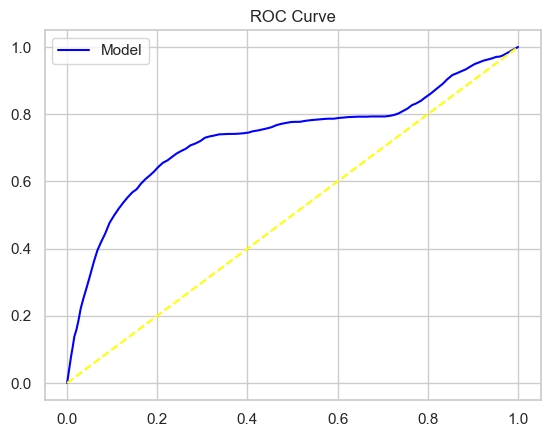

Accuracy 0.79
Precision: 0.14
Recall: 0.64
F1 Score 0.23
AUC: 0.732152970760234
Profit:53957.19
Taxa de Aprovação: 0.78
Taxa de Fraude: 0.023


In [65]:
evaluate_model(X_test['valor_compra'], y_test, y_test_score_modelo_atual, threshold= best_threshold_modelo_atual)

> Portanto, obtivemos um AUC de 0.73, um lucro de 53.957, com uma taxa de aprovação de 0.78 e taxa de fraude 0.023

## Modelo de Ensemble

* Até o presente momento, apenas testamos a possibilidade dos dois modelos funcionarem separadamente. Agora iremos a possibilidade de criar um modelo de ensemble, ou seja um modelo que se utiliza de dois ou mais modelos para chegar em uma predição final.

* Com isso, a partir de agora iremos utilizar a feature "score_fraude_modelo", partindo da premissa que o score do modelo atual será utilizado para ajudar a treinar o modelo novo.

* Logo, iremos treinar novos modelos utilizando essa feature.

* Iremos partir do modelo LGBM, que vimos desempenhar a melhor performance dentre outros modelos.

In [57]:
# ajustamos essa parte do pipeline para não remover a feature "score_fraude_modelo"
columns_to_remove_ensemble = ['produto']

drop_features_ensemble = DropFeatures(features_to_drop=columns_to_remove_ensemble)

Novamente iremos utilizar o MLflow para monitorar nossos modelos.

In [48]:
%%capture
with mlflow.start_run(run_name='LGBM Ensemble Tuned'):

    ratio = float(y_train.value_counts()[0]) / y_train.value_counts()[1]
    model = LGBMClassifier(scale_pos_weight= ratio,random_state=0)

    space_lgbm = {'learning_rate': (0.01, 0.1),
                'num_leaves': (10,100),
                'min_child_samples': (20,120),
                'subsample': (0.1, 1),
                'colsample_bytree': (0.1, 1),
                'max_depth': (3,20)
                }

    bayes_search = BayesSearchCV(model, space_lgbm, cv=5, scoring='roc_auc',
                                 n_iter= 20, verbose=100, random_state=0)

    pipeline = Pipeline([
                         ('missing_indicator', missing_indicator_transformer),
                         ('imputer_N', imputer_N),
                         ('imputer_median', imputer_median),
                         ('imputer_x', imputer_x),
                         ('WOE Encoder', WOEEncoderTransformer(cols=['categoria_produto','pais'])),
                         ('label_encoder', label_encoder),
                         ('hour_extractor', hour_extractor),
                         ('drop_features', drop_features_ensemble),
                         ('model', bayes_search)
                        ])

    pipeline.fit(X_train, y_train)
    
    # metricas de treino
    y_train_pred_ensemble = pipeline.predict(X_train)
    y_train_score_ensemble = pipeline.predict_proba(X_train)[:, 1]

    train_accuracy = metrics.accuracy_score(y_train, y_train_pred_ensemble)
    train_precision = metrics.precision_score(y_train, y_train_pred_ensemble)
    train_recall = metrics.recall_score(y_train, y_train_pred_ensemble)
    train_f1_score = metrics.f1_score(y_train, y_train_pred_ensemble)
    train_auc = metrics.roc_auc_score(y_train, y_train_score_ensemble)
    train_log_loss = metrics.log_loss(y_train, y_train_score_ensemble)
    
    # metricas de teste
    y_test_pred_ensemble = pipeline.predict(X_test)
    y_test_score_ensemble = pipeline.predict_proba(X_test)[:, 1]
    
    test_accuracy = metrics.accuracy_score(y_test, y_test_pred_ensemble)
    test_precision = metrics.precision_score(y_test, y_test_pred_ensemble)
    test_recall = metrics.recall_score(y_test, y_test_pred_ensemble)
    test_f1_score = metrics.f1_score(y_test, y_test_pred_ensemble)
    test_auc = metrics.roc_auc_score(y_test, y_test_score_ensemble)
    test_log_loss = metrics.log_loss(y_test, y_test_score_ensemble)
    
    model_metrics = {"accuracy_train": train_accuracy,
                    "accuracy_test": test_accuracy,
                    "precision_train": train_precision,
                    "precision_test": test_precision,
                    "recall_train": train_recall,
                    "recall_test": test_recall,
                    "f1_score_train": train_f1_score,
                    "f1_score_test": test_f1_score,
                    "auc_train": train_auc,
                    "auc_test": test_auc,
                    "log_loss_train": train_log_loss,
                    "log_loss_test": test_log_loss
                    }
    
    mlflow.log_metrics(model_metrics)
    mlflow.sklearn.log_model(model, "lgbm")

<img src="../../static/mlflow_ensemble.png" style="height: 300px;"/>

<img src="../../static/mlflow_auc_train_test_ensemble.png" style="height: 450px;"/>

> Podemos observar que o modelo de ensemble performou melhor que o modelo novo.

Agora iremos calcular o ponto de corte ótimo para o modelo de ensemble.

In [49]:
best_threshold_ensemble = max_threshold(X_train, y_train_score_ensemble)
best_threshold_ensemble

0.6464646464646465

> Portanto, temos que o ponto de corte que maximiza o lucro para o modelo de ensemble é de aproximadamente 0.64.

Agora, vamos avaliar as métricas para o conjunto de treino com o ponto de corte ótimo.

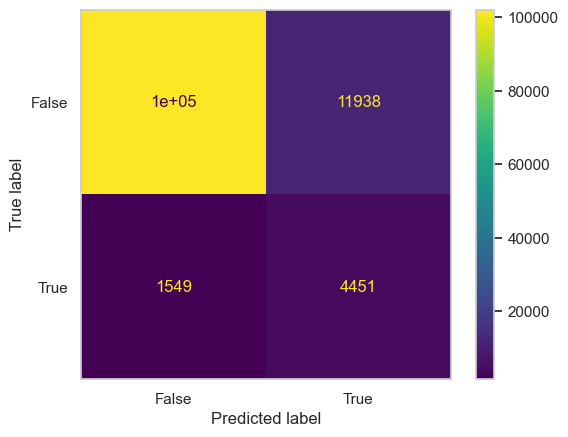

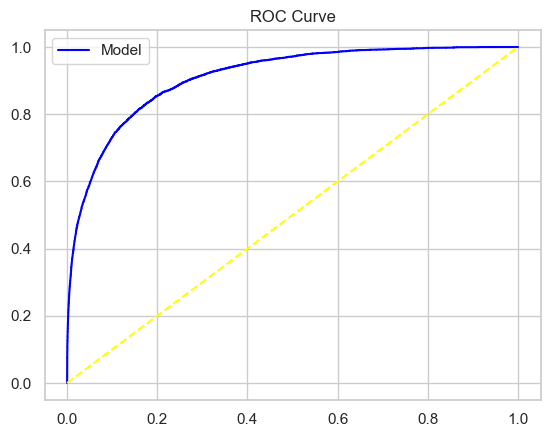

Accuracy 0.89
Precision: 0.27
Recall: 0.74
F1 Score 0.4
AUC: 0.9108466016081872
Profit:324668.20
Taxa de Aprovação: 0.86
Taxa de Fraude: 0.015


In [50]:
evaluate_model(X_train['valor_compra'], y_train, y_train_score_ensemble, threshold= best_threshold_ensemble)

> Portanto, com o modelo de ensemble, conseguimos um lucro de 324.668, com uma taxa de aprovação de 0.86 e taxa de fraude 0.015.

Vamos avaliar também a distribuição dos scores para fraude e não fraude.

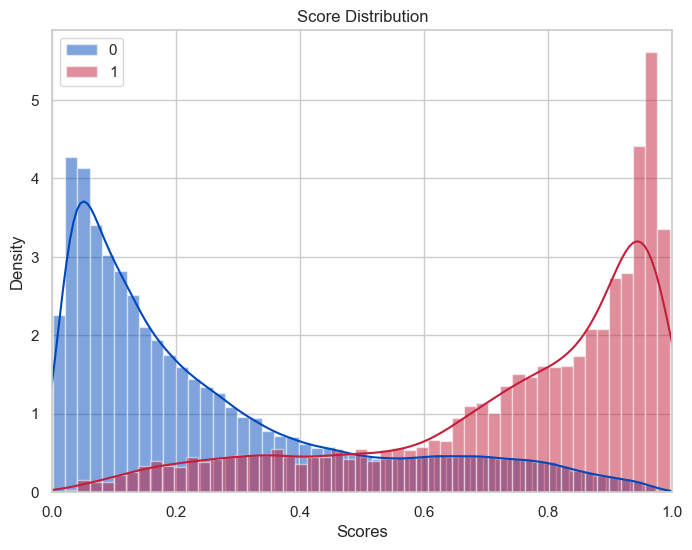

In [67]:
score_distribution(y_train, y_train_score_ensemble)

> Podemos observar que o modelo possui uma capacidade ainda melhor que o modelo novo de discriminação.

Agora vamos analisar para o conjunto de teste

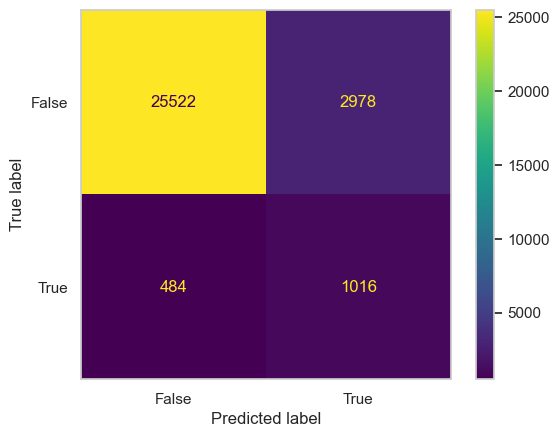

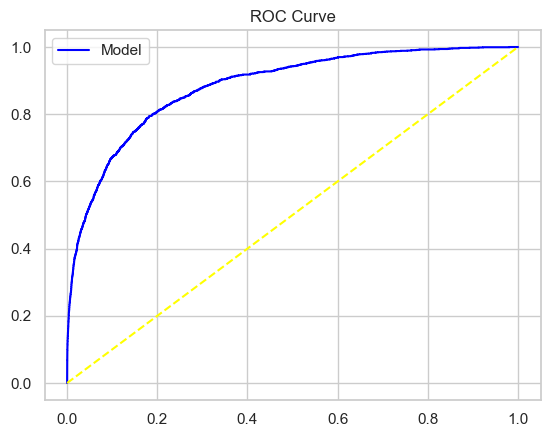

Accuracy 0.88
Precision: 0.25
Recall: 0.68
F1 Score 0.37
AUC: 0.8836403742690059
Profit:72856.40
Taxa de Aprovação: 0.87
Taxa de Fraude: 0.019


In [51]:
evaluate_model(X_test['valor_compra'], y_test, y_test_score_ensemble, threshold= best_threshold_ensemble)

> No conjunto de teste conseguimos um lucro de 72.856, com uma taxa de aprovação de 0.87 e taxa de fraude 0.019.

Avaliando a distribuição dos scores para o conjunto de teste

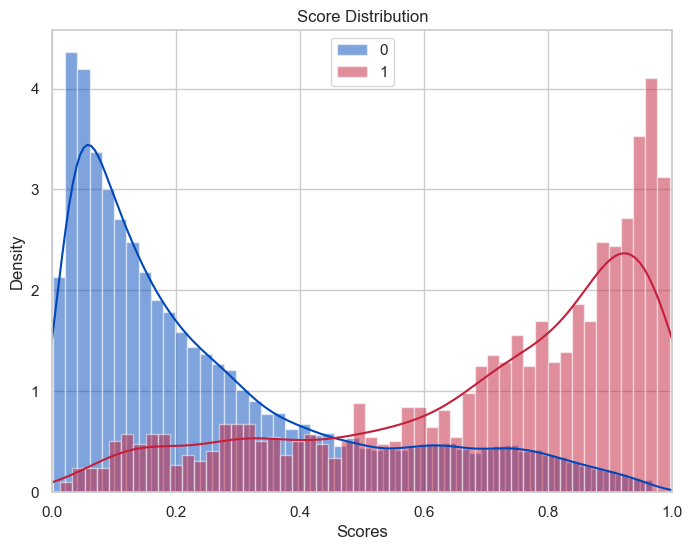

In [68]:
score_distribution(y_test, y_test_score_ensemble)

> Note que ainda temos uma capacidade muito boa de discriminação no modelo de ensemble. Isso aponta que o modelo consegue generalizar.

# Comparação de modelos

Vamos realizar a comparação dos três modelos:

* Modelo atual

* Modelo novo

* Modelo ensemble (atual + novo)

## Métricas do modelo

* Conjunto de Treino (80% dos dados)

|           | Modelo Atual | Modelo Novo | Modelo Ensemble |
|-----------|--------------|-------------|-----------------|
| AUC       | 0.72         | 0.89        | 0.91            |
| Recall    | 0.63         | 0.68        | 0.74            |
| Precision | 0.14         | 0.27        | 0.27            |
| F1-Score  | 0.23         | 0.38        | 0.40            |

* Conjunto de Teste (20% dos dados)

|           | Modelo Atual | Modelo Novo | Modelo Ensemble |
|-----------|--------------|-------------|-----------------|
| AUC       | 0.73         | 0.84        | 0.88            |
| Recall    | 0.64         | 0.57        | 0.68            |
| Precision | 0.14         | 0.23        | 0.25            |
| F1-Score  | 0.23         | 0.33        | 0.37            |

## Métricas de negócio

* Conjunto de treino

|                   | Modelo Atual | Modelo Novo | Modelo Ensemble |
|-------------------|--------------|-------------|-----------------|
| Lucro ($)         | 210.971      | 315.242     | 324.668         |
| Taxa de Aprovação | 0.78         | 0.87        | 0.86            |
| Taxa de Fraude    | 0.024        | 0.018       | 0.015           |

* Conjunto de teste

|                   | Modelo Atual | Modelo Novo | Modelo Ensemble |
|-------------------|--------------|-------------|-----------------|
| Lucro ($)         | 53.957       | 66.136      | 72.856          |
| Taxa de Aprovação | 0.78         | 0.88        | 0.87            |
| Taxa de Fraude    | 0.023        | 0.024       | 0.019           |

## Distribuição dos Lucros

Podemos observar também os gráficos dos pontos de cortes e seus respectivos lucros gerados para a empresa.

* Conjunto de treino

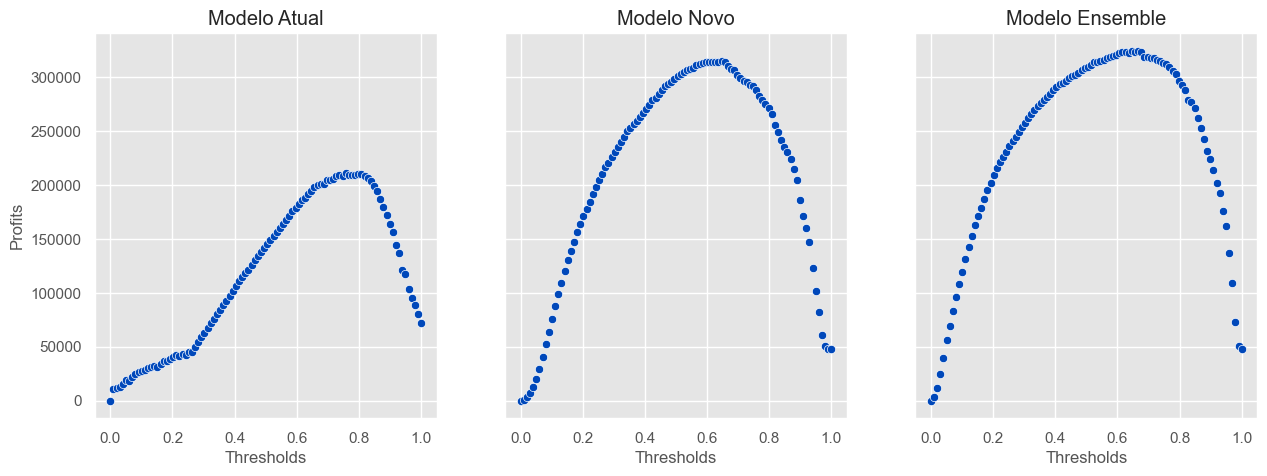

In [128]:
plt.style.use('ggplot')
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

plot_profits(X_train, y_train, y_train_score_modelo_atual, ax=axes[0])
axes[0].set_title('Modelo Atual')

plot_profits(X_train, y_train, y_train_score, ax=axes[1])
axes[1].set_title('Modelo Novo')

plot_profits(X_train, y_train, y_train_score_ensemble, ax=axes[2])
axes[2].set_title('Modelo Ensemble')

plt.show()

* Conjunto de teste

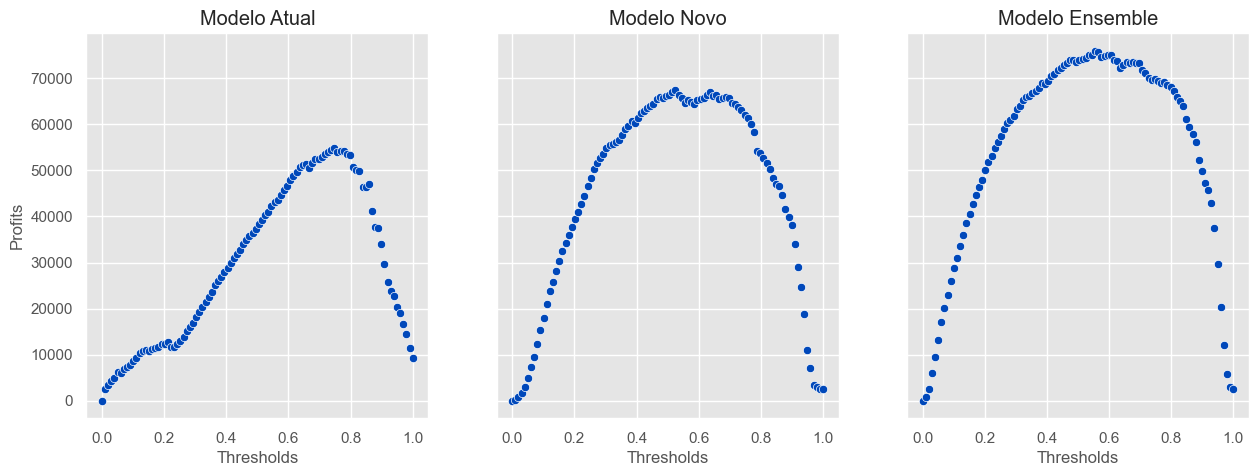

In [129]:
plt.style.use('ggplot')
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

plot_profits(X_test, y_test, y_test_score_modelo_atual, ax=axes[0])
axes[0].set_title('Modelo Atual')

plot_profits(X_test, y_test, y_test_score, ax=axes[1])
axes[1].set_title('Modelo Novo')

plot_profits(X_test, y_test, y_test_score_ensemble, ax=axes[2])
axes[2].set_title('Modelo Ensemble')

plt.show()

> Podemos observar que os lucros do modelo novo são maiores, e com o modelo de ensemble, o lucro se torna ainda maior.

## Distribuição dos scores para fraude e não fraude

* Conjunto de Treino

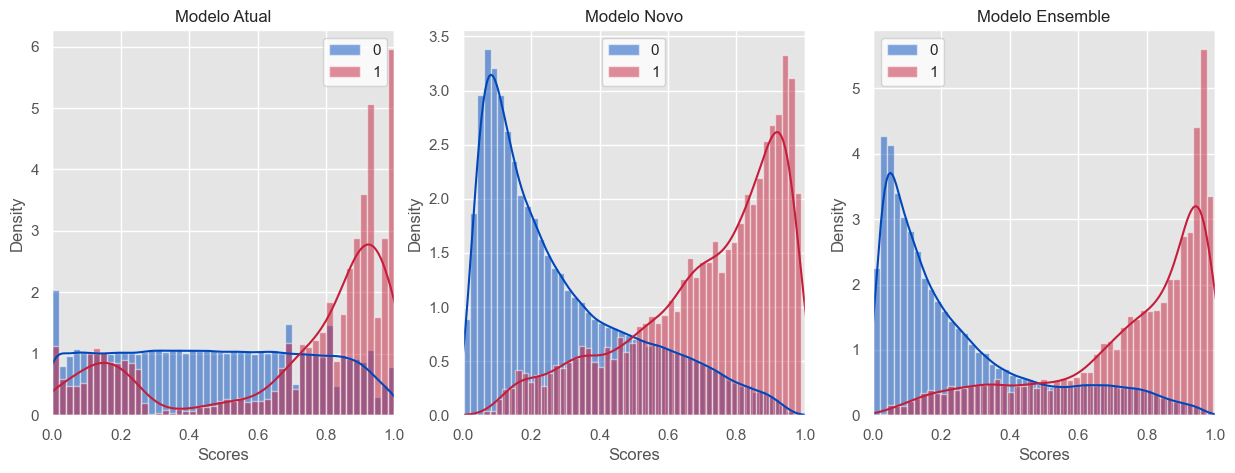

In [106]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

score_distribution(y_train, y_train_score_modelo_atual, ax=axes[0])
axes[0].set_title('Modelo Atual')

score_distribution(y_train, y_train_score, ax=axes[1])
axes[1].set_title('Modelo Novo')

score_distribution(y_train, y_train_score_ensemble, ax=axes[2])
axes[2].set_title('Modelo Ensemble')

plt.show()

* Conjunto de Teste

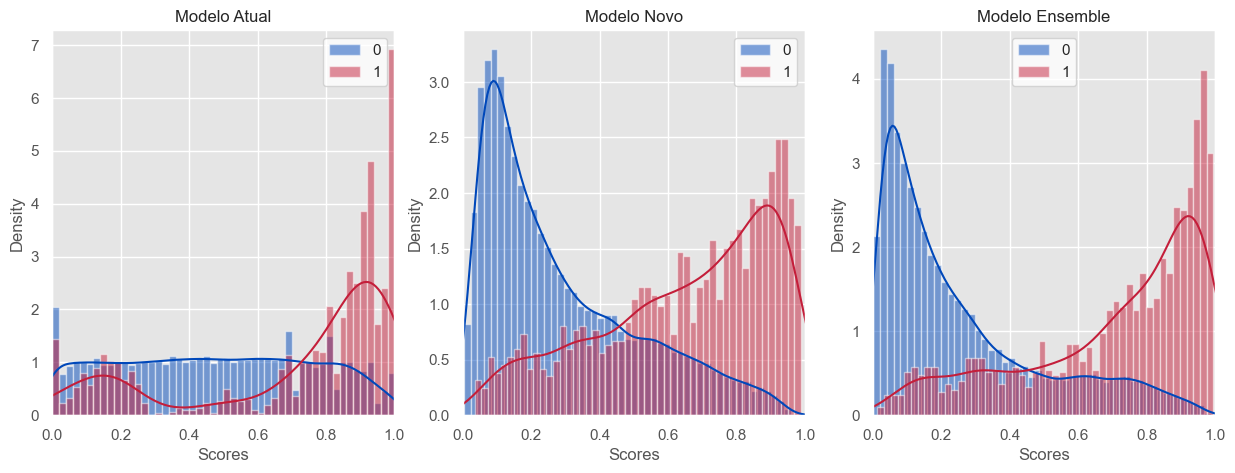

In [108]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

score_distribution(y_test, y_test_score_modelo_atual, ax=axes[0])
axes[0].set_title('Modelo Atual')

score_distribution(y_test, y_test_score, ax=axes[1])
axes[1].set_title('Modelo Novo')

score_distribution(y_test, y_test_score_ensemble, ax=axes[2])
axes[2].set_title('Modelo Ensemble')

plt.show()

> É evidente a melhora na capacidade de discriminação do modelo novo para o modelo atual. Juntando os dois modelos, conseguimos melhorar ainda um pouco mais a performance final.

# Conclusão

Por fim, podemos concluir alguns pontos:

## Métricas do modelo

* O modelo novo desempenhou melhor que o modelo atual, apresentando um AUC de 0.73 vs 0.84 para o modelo atual no conjunto de teste. Com o modelo de ensemble, foi possível uma melhoria ainda maior no modelo, alcançando 0.88 de AUC.

* Ao plotarmos o gráfico de distribuições, é evidente que o modelo novo tem uma capacidade melhor de discriminação de transações fraudulentas e não fraudulentas.

* Tanto o modelo novo quanto o de ensemble, possuem um shift de performance entre treino e teste muito bom. Para o modelo novo, temos em treino 0.89 de AUC vs 0.84 em teste. Para o modelo de ensemble, temos 0.91 vs 0.88.

* Com isso, conseguimos concluir que, além de alcançarmos um modelo que performa significativamente melhor que o modelo atual, chegamos a modelos estáveis, que por conta de ter um shift baixo, aponta ser um modelo generalista. 

## Métricas de negócio

* Ao analisarmos a métrica de lucro da empresa, conseguimos alcançar, no conjunto de teste, um aumento de 23% com o novo modelo, e um aumento de 35% com o modelo de ensemble.

* Quanto à métrica de taxa de aprovação, conseguimos aumentar, no conjunto de teste, de 78% para 88% (10pp), com o modelo novo, e com o modelo de ensemble 9pp.

* Em relação à taxas de fraude, conseguimos reduzir a taxa de 2.3% para 1.8% no conjunto de treino para o modelo novo, e para 1.5% no modelo de ensemble. Entretanto, no conjunto de teste, no modelo novo a taxa de fraude sobe para 0.1% e o modelo de ensemble possui 1.9% de fraude.

* Por fim, ao analisarmos qual modelo devemos implantar em produção, devemos também considerar o custo de manutenção do modelo atual, visto que para termos um modelo de ensemble, teríamos que ter dois modelos rodando ao mesmo tempo. Feito esse estudo, podemos comparar qual é a alternativa mais lucrativa para a empresa.